In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from scipy.stats import ks_2samp, mannwhitneyu
from sklearn.metrics import average_precision_score

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_recall_curve,
    classification_report
)
pd.set_option("display.max_rows", None)

In [2]:
df = pd.read_parquet("DATA/dataset/train_stage2")

In [39]:
df.shape

(5312711, 50)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5312711 entries, 0 to 5332978
Data columns (total 61 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   date                            datetime64[ns]
 1   client_id                       int64         
 2   card_id                         int64         
 3   amount                          float32       
 4   merchant_id                     int64         
 5   mcc                             object        
 6   fraud                           int8          
 7   has_error                       int8          
 8   err_bad_card_number             int8          
 9   err_bad_expiration              int8          
 10  err_bad_cvv                     int8          
 11  err_bad_pin                     int8          
 12  err_bad_zipcode                 int8          
 13  err_insufficient_balance        int8          
 14  err_technical_glitch            int8          
 15  tx_

In [24]:
LABEL = "fraud"

# 1️⃣ Time

👉 언제 발생했는가?

**목적**

시간대 기반 취약 구간 확인

fraud가 특정 시간에 몰리는가?

정상 거래 대비 구조적 차이가 있는가?

**분석 포인트**

hour / weekday / month

야간 vs 주간 fraud rate

주말 vs 평일

시간 × error 교차

시간 × refund 교차

### 연도별 fraud rate

In [25]:
year = df["tx_year"].unique()

In [26]:
a = df["tx_year"].value_counts()

In [27]:
a

tx_year
2015    926286
2014    911271
2013    903737
2012    882171
2011    860219
2010    829027
Name: count, dtype: int64

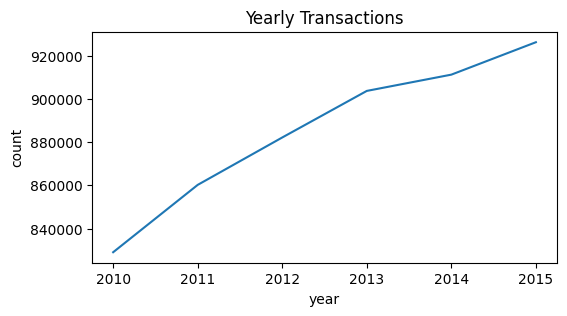

In [28]:
plt.figure(figsize=(6,3))
a.plot()
plt.title("Yearly Transactions")
plt.xlabel("year")
plt.ylabel("count")
plt.show()

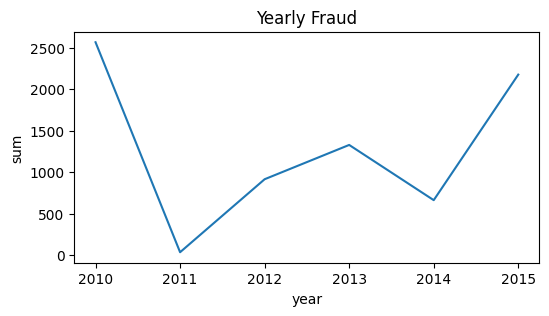

tx_year
2010    2566
2011      37
2012     916
2013    1329
2014     664
2015    2176
Name: fraud, dtype: int64

tx_year
2010    0.003095
2011    0.000043
2012    0.001038
2013    0.001471
2014    0.000729
2015    0.002349
Name: fraud, dtype: float64


In [29]:
yearly_fraud = (
    df
    .groupby("tx_year")[LABEL]
    .sum()
)
plt.figure(figsize=(6,3))
yearly_fraud.plot()
plt.title("Yearly Fraud")
plt.xlabel("year")
plt.ylabel("sum")
plt.show()
print(yearly_fraud)
print()
yearly_fraud = (
    df
    .groupby("tx_year")[LABEL]
    .mean()
)
print(yearly_fraud)


### 월별 fraud rate heatmap

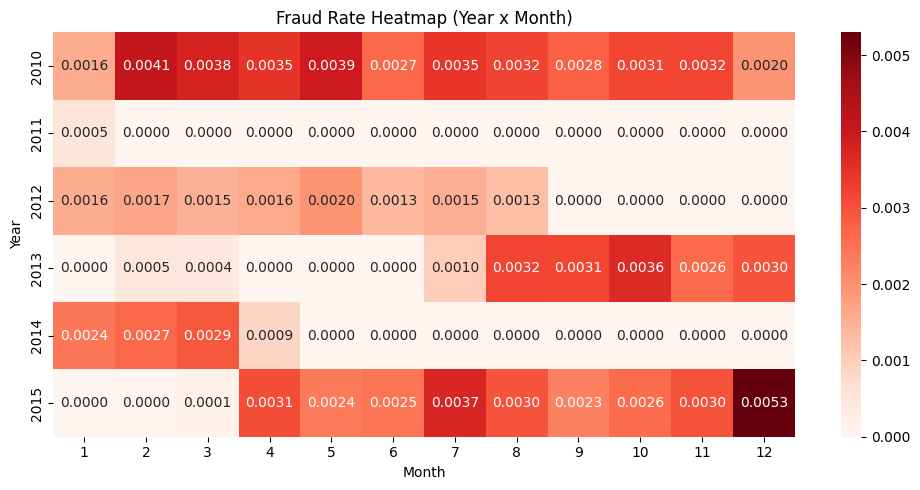

In [30]:
pivot_df = (
    df.groupby(["tx_year", "tx_month"])[LABEL]
    .mean()
    .unstack()
)
plt.figure(figsize=(10, 5))
sns.heatmap(
    pivot_df,
    annot=True,
    fmt=".4f",
    cmap="Reds"
)
plt.title("Fraud Rate Heatmap (Year x Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

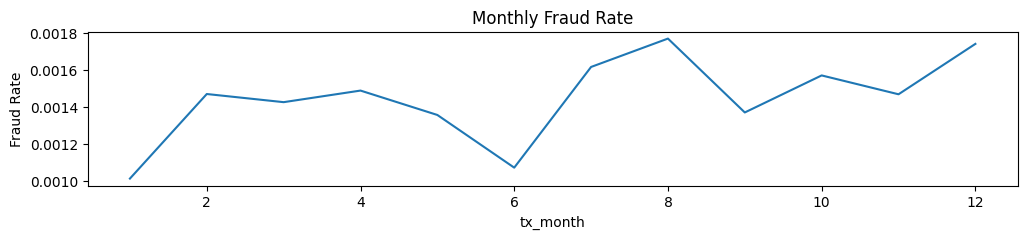

tx_month
1     0.001011
2     0.001468
3     0.001424
4     0.001487
5     0.001355
6     0.001070
7     0.001615
8     0.001768
9     0.001369
10    0.001569
11    0.001467
12    0.001740
Name: fraud, dtype: float64


In [31]:
monthly_fraud = (
    df
    .groupby("tx_month")[LABEL]
    .mean()
)

plt.figure(figsize=(12,2))
monthly_fraud.plot()
plt.title("Monthly Fraud Rate")
plt.ylabel("Fraud Rate")
plt.show()
print(monthly_fraud)


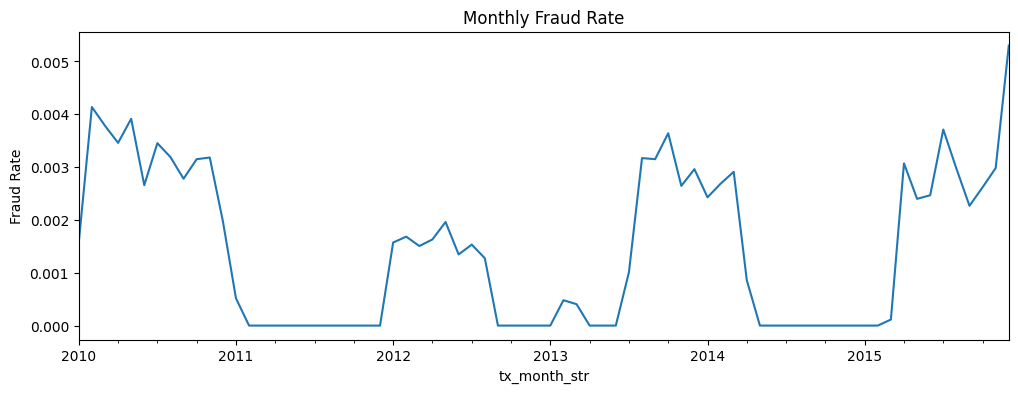

In [32]:
monthly_fraud = (
    df
    .assign(tx_month_str=df["date"].dt.to_period("M"))
    .groupby("tx_month_str")[LABEL]
    .mean()
)

plt.figure(figsize=(12,4))
monthly_fraud.plot()
plt.title("Monthly Fraud Rate")
plt.ylabel("Fraud Rate")
plt.show()

**2011년 drop or not?**

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5312711 entries, 0 to 5332978
Data columns (total 61 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   date                            datetime64[ns]
 1   client_id                       int64         
 2   card_id                         int64         
 3   amount                          float32       
 4   merchant_id                     int64         
 5   mcc                             object        
 6   fraud                           int8          
 7   has_error                       int8          
 8   err_bad_card_number             int8          
 9   err_bad_expiration              int8          
 10  err_bad_cvv                     int8          
 11  err_bad_pin                     int8          
 12  err_bad_zipcode                 int8          
 13  err_insufficient_balance        int8          
 14  err_technical_glitch            int8          
 15  tx_

In [34]:
df.isnull().sum()

date                              0
client_id                         0
card_id                           0
amount                            0
merchant_id                       0
mcc                               0
fraud                             0
has_error                         0
err_bad_card_number               0
err_bad_expiration                0
err_bad_cvv                       0
err_bad_pin                       0
err_bad_zipcode                   0
err_insufficient_balance          0
err_technical_glitch              0
tx_year                           0
tx_month                          0
tx_day                            0
tx_hour                           0
is_weekend                        0
is_refund                         0
log_abs_amount                    0
mccg_Food_Daily                   0
mccg_Transport_Travel             0
mccg_Digital_Online               0
mccg_Financial                    0
mccg_Retail                       0
mccg_Medical                

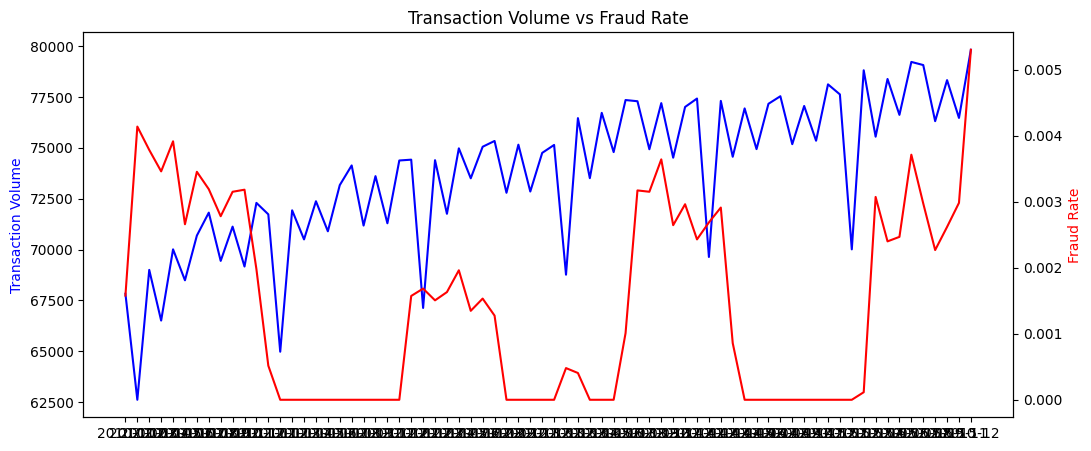

In [36]:
monthly_full = (
    df.groupby(["tx_year", "tx_month"])["fraud"]
      .agg(["mean", "count"])
      .reset_index()
)

monthly_full["year_month"] = (
    monthly_full["tx_year"].astype(str) + "-" +
    monthly_full["tx_month"].astype(str).str.zfill(2)
)

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(monthly_full["year_month"], monthly_full["count"], color="blue")
ax1.set_ylabel("Transaction Volume", color="blue")

ax2 = ax1.twinx()
ax2.plot(monthly_full["year_month"], monthly_full["mean"], color="red")
ax2.set_ylabel("Fraud Rate", color="red")

plt.xticks(rotation=90)
plt.title("Transaction Volume vs Fraud Rate")
plt.show()

### 일별 fraud rate

tx_day
1     0.001453
2     0.001441
3     0.001245
4     0.001392
5     0.001665
6     0.001592
7     0.001466
8     0.001322
9     0.001404
10    0.001262
11    0.001169
12    0.001605
13    0.001206
14    0.001278
15    0.001531
16    0.001320
17    0.001137
18    0.001647
19    0.001743
20    0.001306
21    0.001413
22    0.001447
23    0.001600
24    0.001233
25    0.001354
26    0.001649
27    0.001710
28    0.001658
29    0.001727
30    0.001366
31    0.001613
Name: fraud, dtype: float64


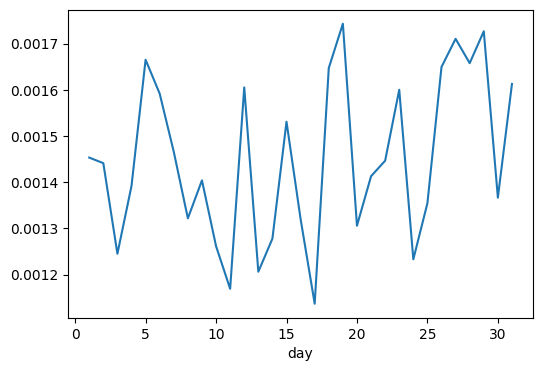

In [46]:
LABEL = "fraud"

day = (
    df
    .groupby("tx_day")[LABEL]
    .mean()
)

plt.figure(figsize=(6, 4))
day.plot()
plt.xlabel("day")
plt.ylabel("")

print(day)

weekday
6    0.002206
4    0.002016
0    0.001626
5    0.001280
1    0.001261
3    0.000920
2    0.000816
Name: fraud, dtype: float64


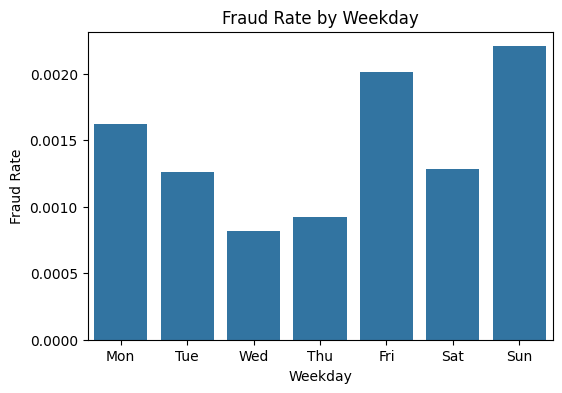

In [ ]:
weekday_rate = (
    df.groupby("weekday")["fraud"]
      .mean()
      .sort_values(ascending=False)
)

print(weekday_rate)

weekday_map = {
    0: "Mon", 1: "Tue", 2: "Wed",
    3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"
}

weekday_df = weekday_rate.reset_index()
weekday_df.columns = ["weekday", "fraud_rate"]

weekday_df["weekday_name"] = weekday_df["weekday"].map(weekday_map)

# 순서 정렬 (Mon→Sun)
weekday_df = weekday_df.sort_values("weekday")

plt.figure(figsize=(6,4))
sns.barplot(data=weekday_df, x="weekday_name", y="fraud_rate")
plt.xlabel("Weekday")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Weekday")
plt.show()

In [41]:
df["weekday_name"] = df["date"].dt.day_name().str[:3]

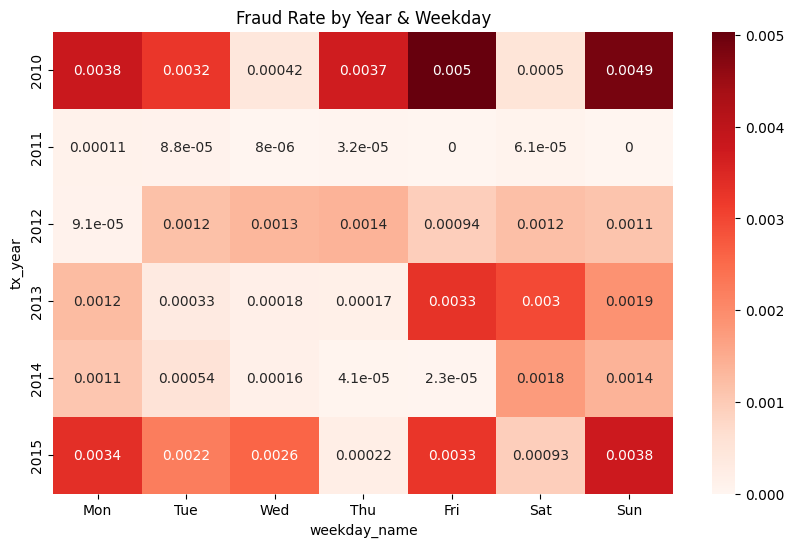

In [40]:
pivot_weekday = (
    df.groupby(["tx_year", "weekday_name"])["fraud"]
      .mean()
      .unstack()
      .reindex(columns=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
)
plt.figure(figsize=(10,6))
sns.heatmap(pivot_weekday, cmap="Reds", annot=True)
plt.title("Fraud Rate by Year & Weekday")
plt.show()


weekday는 stable main effect라기보다\
time-varying effect

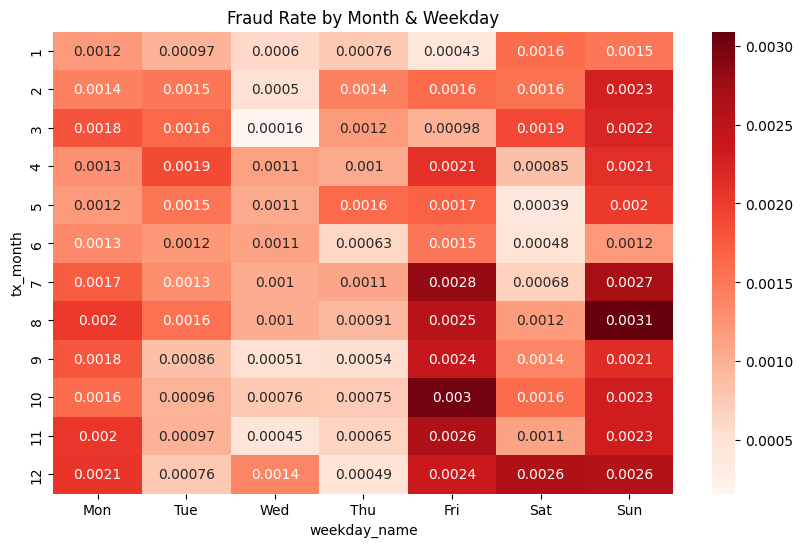

In [41]:
pivot_weekday = (
    df.groupby(["tx_month", "weekday_name"])["fraud"]
      .mean()
      .unstack()
      .reindex(columns=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
)
plt.figure(figsize=(10,6))
sns.heatmap(pivot_weekday, cmap="Reds", annot=True)
plt.title("Fraud Rate by Month & Weekday")
plt.show()


In [42]:
month_weekday = df.groupby(["tx_month", "weekday"])["fraud"].mean().unstack()

month_weekday.idxmax(axis=1)

tx_month
1     5
2     6
3     6
4     6
5     6
6     4
7     4
8     6
9     4
10    4
11    4
12    5
dtype: int32

### 시간별 fraud rate

tx_hour
0     0.000234
1     0.000824
2     0.000837
3     0.002464
4     0.002833
5     0.003024
6     0.001457
7     0.001398
8     0.001400
9     0.002283
10    0.002405
11    0.002170
12    0.001825
13    0.001987
14    0.001566
15    0.001433
16    0.001112
17    0.000821
18    0.000461
19    0.000533
20    0.000113
21    0.000125
22    0.000066
23    0.000333
Name: fraud, dtype: float64


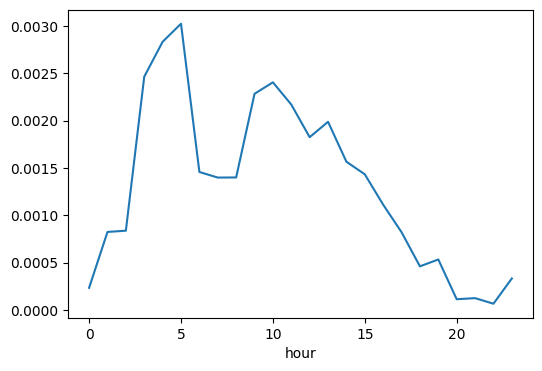

In [43]:
hour = (
    df
    .groupby("tx_hour")[LABEL]
    .mean()
)

plt.figure(figsize=(6, 4))
hour.plot()
plt.xlabel("hour")
plt.ylabel("")

print(hour)

tx_day → 의미 없음 (PASS)

weekday → 의미 있음 (유지)

year × weekday → drift 존재

month × weekday → 구조 일관성 존재

### validate

In [44]:
check = df.groupby(["tx_month", "weekday"])["fraud"].agg(["mean","count"])

In [45]:
check.head(84)

mean  count
tx_month weekday                 
1        0        0.001198  62600
         1        0.000974  62603
         2        0.000600  61705
         3        0.000760  64446
         4        0.000433  64606
         5        0.001601  64332
         6        0.001502  63905
2        0        0.001408  58227
         1        0.001508  58337
         2        0.000504  57525
         3        0.001413  57316
         4        0.001618  57491
         5        0.001555  57230
         6        0.002280  57026
3        0        0.001798  66176
         1        0.001641  65205
         2        0.000161  62189
         3        0.001183  61685
         4        0.000979  62310
         5        0.001895  64918
         6        0.002216  65445
4        0        0.001273  62830
         1        0.001870  63094
         2        0.001135  62569
         3        0.001049  61957
         4        0.002103  61824
         5        0.000853  59778
         6        0.002121  60355
5        0        0.001197  63510
         1        0.001526  62902
         2        0.001052  62712
         3        0.001616  65580
         4        0.001694  64941
         5        0.000386  64845
         6        0.002002  64941
6        0        0.001329  64687
         1        0.001219  63974
         2        0.001112  62942
         3        0.000628  60506
         4        0.001511  60888
         5        0.000476  62983
         6        0.001201  63285
7        0        0.001718  64619
         1        0.001310  66431
         2        0.001025  65356
         3        0.001083  65543
         4        0.002807  65189
         5        0.000684  62821
         6        0.002695  62715
8        0        0.002012  67094
         1        0.001564  63954
         2        0.001020  63735
         3        0.000906  62887
         4        0.002547  65949
         5        0.001169  65880
         6        0.003089  65716
9        0        0.001778  64670
         1        0.000858  64077
         2        0.000507  63072
         3        0.000538  63218
         4        0.002404  60734
         5        0.001381  60815
         6        0.002149  63275
10       0        0.001599  63776
         1        0.000959  63624
         2        0.000763  65538
         3        0.000750  65348
         4        0.003012  65731
         5        0.001603  65497
         6        0.002302  62990
11       0        0.002048  63971
         1        0.000973  63702
         2        0.000446  60476
         3        0.000654  61187
         4        0.002632  63449
         5        0.001120  63381
         6        0.002315  63506
12       0        0.002067  67247
         1        0.000764  66785
         2        0.001379  65990
         3        0.000487  65711
         4        0.002358  63184
         5        0.002625  63613
         6        0.002583  63875

-> 단순 거래량 때문 아님 

Fri/Sun이 높게 나오는 건\
거래량이 많아서가 아니라\
conditional fraud probability 자체가 높은 것.

df["weekday"] = df["date"].dt.weekday -> 이 피처 필요함!

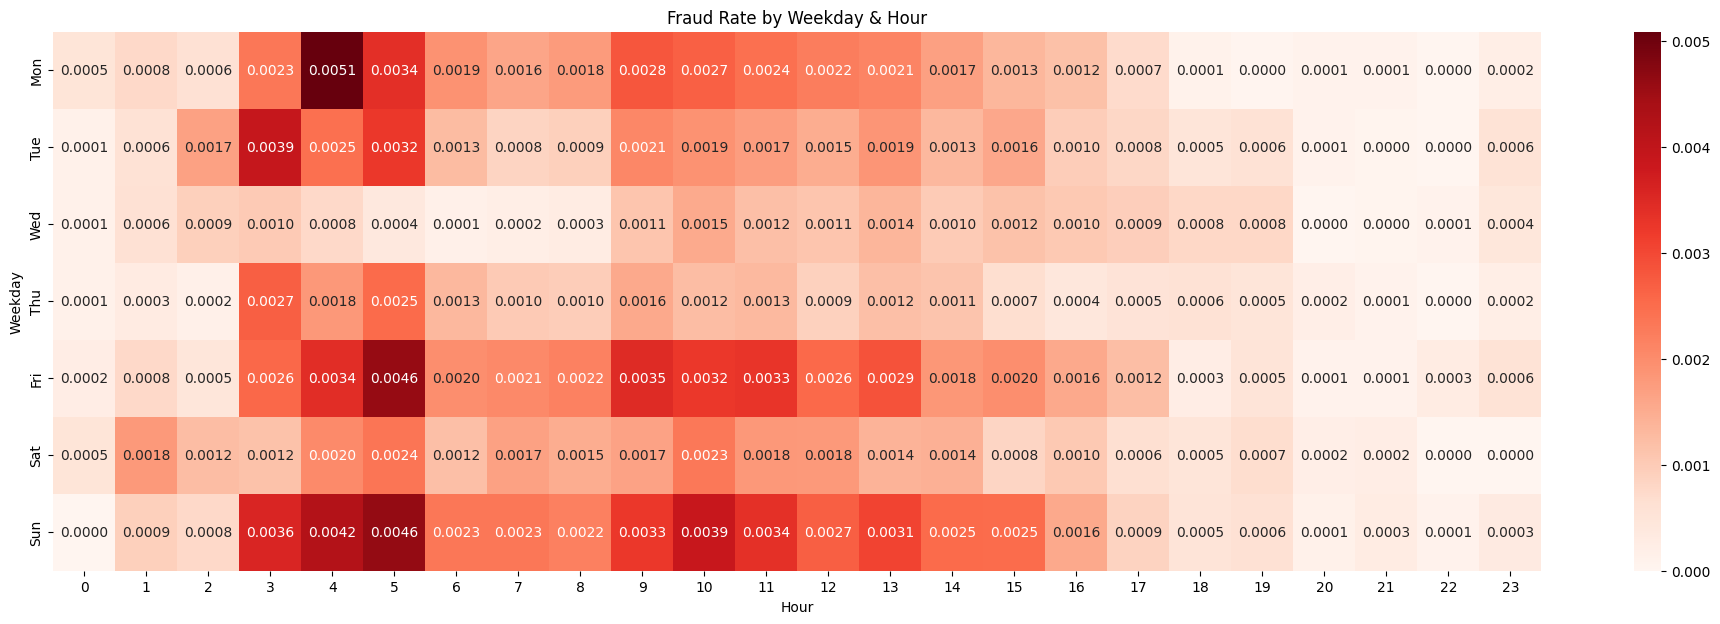

In [46]:
pivot_weekday_hour = (
    df.groupby(["weekday_name", "tx_hour"])["fraud"]
      .mean()
      .unstack()  # hour가 column으로
      .reindex(index=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
)

plt.figure(figsize=(24,7))
sns.heatmap(
    pivot_weekday_hour,
    cmap="Reds",
    annot=True,
    fmt=".4f"
)
plt.title("Fraud Rate by Weekday & Hour")
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.show()

새벽 3~5시

Fri / Sun에서 강하게 높음

Mon도 4~5시 꽤 높음

Wed는 거의 안 튐

=> 야간 고위험 구간 구조

====================

저녁 18시 이후

전반적으로 낮아짐

시간대 효과가 사라짐

====================

Wed는:

거의 모든 시간대에서 낮음

새벽에도 안 튐

낮에도 중간 이하

일관된 low-risk weekday

=> tx_hour 중요

====================

**1️⃣ 연도**

2011은 희박년도

연도별 magnitude drift 존재

**2️⃣ 월**

약한 계절성

특정 월에서 Fri/Sun 강화

**3️⃣ 요일**

Fri/Sun consistently high-risk

Wed consistently low-risk

**4️⃣ 시간대**

새벽 3~5시 + Fri/Sun 결합 시 상승

interaction 존재

**5️⃣ 거래량 영향 아님**

count 거의 균등

conditional probability 차이임

In [122]:
df["hour_sin"] = np.sin(2 * np.pi * df["tx_hour"] / 24).astype("float32")
df["hour_cos"] = np.cos(2 * np.pi * df["tx_hour"] / 24).astype("float32")

---

# 2️⃣ Behavioral / Transaction-Level

👉 이 한 건의 거래는 어떤 행동인가?


## (A) 금액 구조

log_abs_amount

amount_income_ratio

amount_limit_ratio

## (B) 소비 맥락

mcc


## (C) 환불 구조

is_refund

## (D) 카드 유형

is_credit

is_prepaid

cb_*


### **금액 구조**

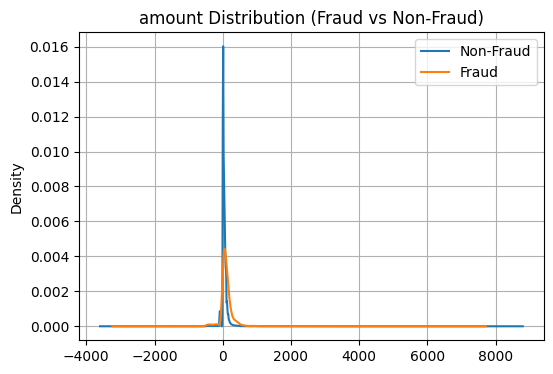

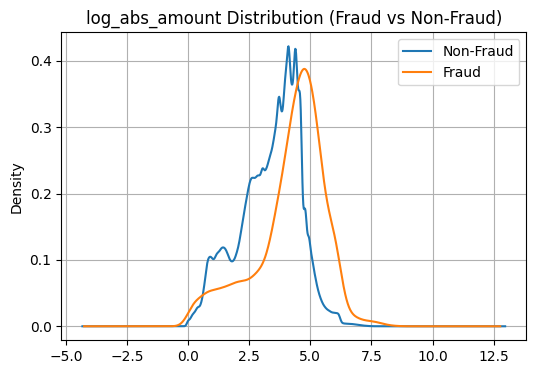

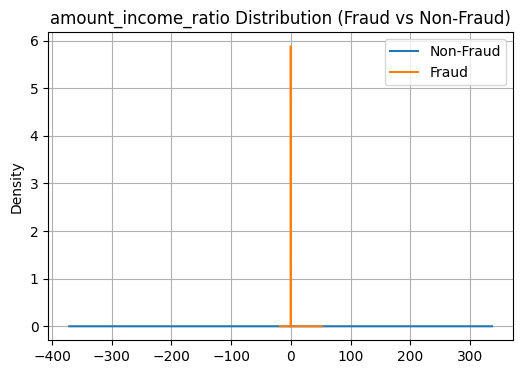

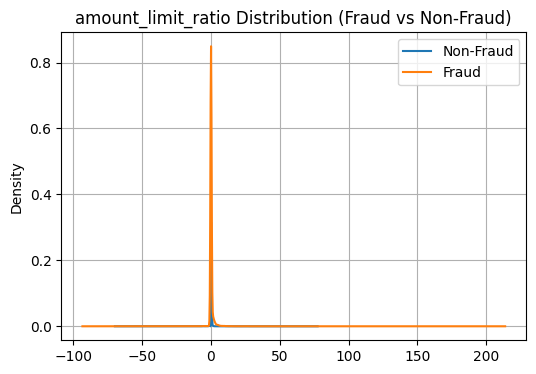

In [48]:
money_cols = [
    "amount",
    "log_abs_amount",
    "amount_income_ratio",
    "amount_limit_ratio"
]

for col in money_cols:
    plt.figure(figsize=(6,4))
    
    df[df["fraud"] == 0][col].plot(kind="kde", label="Non-Fraud")
    df[df["fraud"] == 1][col].plot(kind="kde", label="Fraud")
    
    plt.title(f"{col} Distribution (Fraud vs Non-Fraud)")
    plt.legend()
    plt.grid(True)
    plt.show()

> Fraud는 non-fraud 대비 더 큰 금액에서 발생할 확률이 높다

In [49]:
df["credit_limit"].describe()

count    5.312711e+06
mean     1.553429e+04
std      1.218885e+04
min      1.000000e+00
25%      8.100000e+03
50%      1.343400e+04
75%      2.082700e+04
max      1.413910e+05
Name: credit_limit, dtype: float64

In [3]:
non_refund = df.loc[df["is_refund"] == 0].copy()
non_refund["log_amount_income_ratio"] = np.log1p(
    non_refund["amount_income_ratio"].values
)

In [4]:
non_refund["log_amount_income_ratio"].describe()

count    5.046473e+06
mean     2.182090e-03
std      4.439826e-02
min      0.000000e+00
25%      2.571706e-04
50%      7.494310e-04
75%      1.596254e-03
max      5.081403e+00
Name: log_amount_income_ratio, dtype: float64

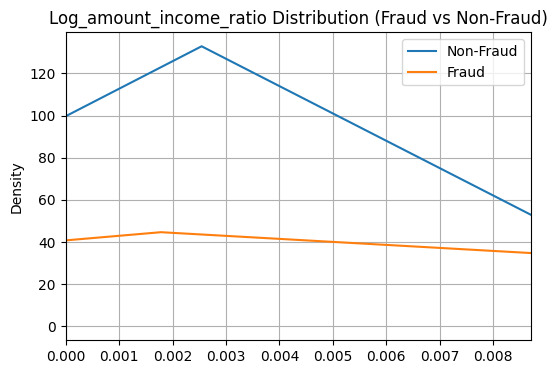

In [7]:
xmax = non_refund["log_amount_income_ratio"].quantile(0.99)
plt.figure(figsize=(6,4))
non_refund[non_refund["fraud"]==0]["log_amount_income_ratio"].plot(kind="kde", label="Non-Fraud")
non_refund[non_refund["fraud"]==1]["log_amount_income_ratio"].plot(kind="kde", label="Fraud")
plt.title(f"Log_amount_income_ratio Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.xlim(0, xmax)
plt.grid(True)
plt.show()

In [9]:
refund = df.loc[df["is_refund"]==1].copy()
refund["log_refund_income_ratio"] = np.log1p(refund["amount_income_ratio"].abs().values)

In [12]:
refund["log_refund_income_ratio"].describe()

count    2.662380e+05
mean     2.759371e-03
std      1.125277e-02
min      2.243007e-07
25%      1.382920e-03
50%      1.895017e-03
75%      2.637568e-03
max      5.272999e+00
Name: log_refund_income_ratio, dtype: float64

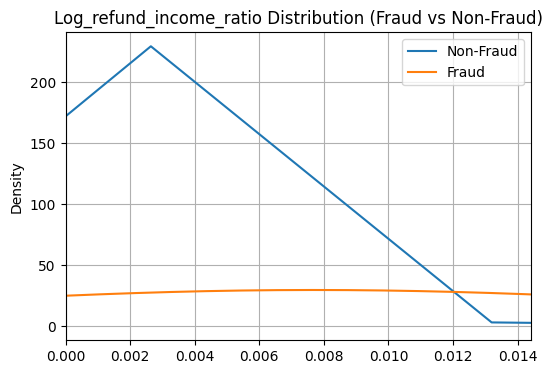

In [14]:
xmax = refund["log_refund_income_ratio"].quantile(0.99)
plt.figure(figsize=(6,4))
refund[refund["fraud"]==0]["log_refund_income_ratio"].plot(kind="kde", label="Non-Fraud")
refund[refund["fraud"]==1]["log_refund_income_ratio"].plot(kind="kde", label="Fraud")
plt.title(f"Log_refund_income_ratio Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.xlim(0, xmax)
plt.grid(True)
plt.show()

> fraud 거래는 income 대비 극단적으로 큰 비율을 잘 안 가진다

> Fraud 거래는 income 대비 비정상적으로 큰 비율을 보이는 패턴이 두드러지지 않는다.\
> 오히려 일정 범위 내에서 분포가 형성되어 있다.

### **소비맥락**

In [15]:
df["mcc"].value_counts()

mcc
5411    635583
5499    585630
5541    572901
5812    399356
5912    308891
4784    258849
5300    241670
4829    237812
5814    199405
4121    196895
5311    190324
7538    190099
5813     99804
5310     99120
4900     96933
5942     92447
4814     87227
5211     69715
7832     56766
5921     51510
7230     42677
9402     39559
4214     39388
4111     34589
5719     34528
5651     28835
5970     26813
5815     25344
4899     20888
7349     20727
6300     20627
7542     15756
7922     15575
5251     14274
8021     12998
4722     12864
7995     12828
7210     12608
8011      9801
7801      7033
5655      6717
7011      6652
7802      6516
8043      6433
3684      6362
3504      6335
3509      6315
3722      6240
3640      5981
3780      5884
8099      5846
3596      5783
3730      5767
3771      5699
3775      5543
5661      5336
7393      5186
7996      4634
3359      4448
5192      4181
5621      4158
8049      4122
3389      4107
8041      4021
5193      3637
3387      3468
3395  

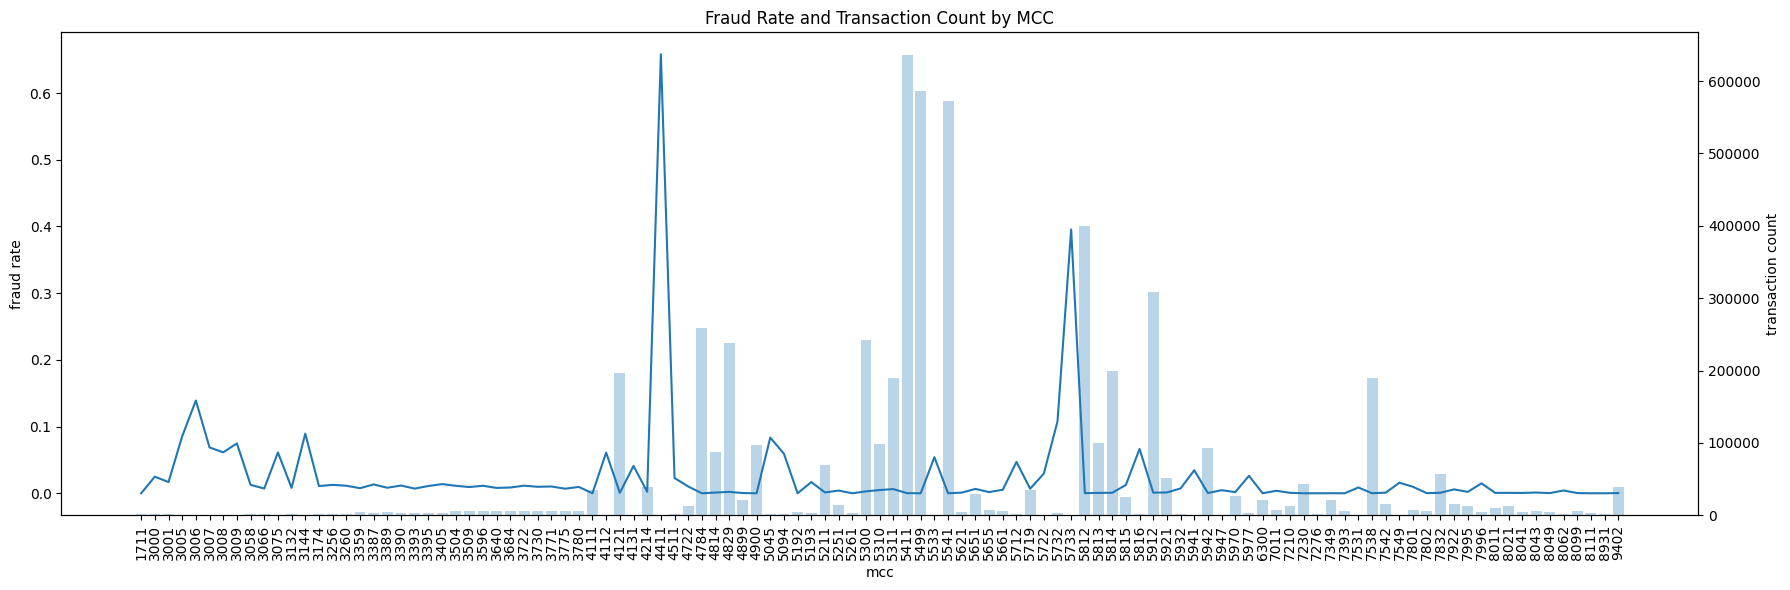

In [29]:
mcc_rate = df.groupby("mcc")["fraud"].mean()
mcc_count = df.groupby("mcc")["fraud"].count()

mcc_rate = mcc_rate.sort_index()
mcc_count = mcc_count.sort_index()

fig, ax1 = plt.subplots(figsize=(18,6))

# fraud rate
ax1.plot(mcc_rate.index.astype(str), mcc_rate.values)
ax1.set_xlabel("mcc")
ax1.set_ylabel("fraud rate")

ax1.set_xticks(range(len(mcc_rate)))
ax1.set_xticklabels(mcc_rate.index.astype(str), rotation=90)

# count
ax2 = ax1.twinx()
ax2.bar(range(len(mcc_count)), mcc_count.values, alpha=0.3)
ax2.set_ylabel("transaction count")

plt.title("Fraud Rate and Transaction Count by MCC")
plt.tight_layout()
plt.show()


In [36]:
mcc_data = pd.concat([mcc_rate, mcc_count], axis=1)
mcc_data.columns = ["fraud_rate", "tx_count"]
mcc_data = mcc_data.sort_values("fraud_rate", ascending=False)
mcc_data.head(100)

,fraud_rate,tx_count
mcc,,
4411,0.658163,196
5733,0.395522,134
3006,0.139073,151
5732,0.107561,2817
3144,0.089431,123
3005,0.085366,164
5045,0.083486,1090
3009,0.074830,147
3007,0.068750,160


In [32]:
df.groupby("mcc")["fraud"].mean().sort_values(ascending=False)

mcc
4411    0.658163
5733    0.395522
3006    0.139073
5732    0.107561
3144    0.089431
3005    0.085366
5045    0.083486
3009    0.074830
3007    0.068750
5816    0.066492
3008    0.061350
3075    0.061224
4112    0.061043
5094    0.059220
5533    0.054108
5712    0.046989
4131    0.041020
5941    0.034483
5722    0.029412
5977    0.026198
3000    0.024903
4511    0.022920
3001    0.016813
5193    0.016772
7549    0.015766
7996    0.014890
3405    0.013759
3387    0.013264
3058    0.012648
3256    0.012567
5815    0.012468
3390    0.011614
3722    0.011378
3260    0.011324
3596    0.011240
3504    0.011208
3395    0.010914
3174    0.010850
4722    0.010183
3771    0.010177
3730    0.009710
7801    0.009669
3780    0.009517
3509    0.009343
7531    0.008658
3684    0.008645
3389    0.008279
3132    0.008065
3640    0.008025
3359    0.007644
5932    0.007253
3066    0.007086
3393    0.007025
3775    0.006855
5719    0.006835
5651    0.006555
5311    0.006242
7922    0.005843
5661    0.

- 4411: Cruise Lines
- 5733: Music Stores - Musical Instruments

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5312711 entries, 0 to 5332978
Data columns (total 51 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   date                      datetime64[ns]
 1   client_id                 int64         
 2   card_id                   int64         
 3   amount                    float32       
 4   merchant_id               int64         
 5   mcc                       object        
 6   fraud                     int8          
 7   has_error                 int8          
 8   err_bad_card_number       int8          
 9   err_bad_expiration        int8          
 10  err_bad_cvv               int8          
 11  err_bad_pin               int8          
 12  err_bad_zipcode           int8          
 13  err_insufficient_balance  int8          
 14  err_technical_glitch      int8          
 15  tx_year                   int16         
 16  tx_month                  int8          
 17  tx_day       

| mcc  | fraud_rate | tx_count | mcc |
| ---- | ---------- | -------- | -------- |
| 5732 | 0.107      | 2817     | Electronics Stores |
| 5045 | 0.083      | 1090     | Computers, Computer Peripheral Equipment |
| 5816 | 0.066      | 1143     | Digital Goods - Games |
| 5094 | 0.059      | 2077     | Precious Stones and Metals |
| 5712 | 0.046      | 1511     | Furniture, Home Furnishings, and Equipment Stores |


- 5732 — Electronics Stores

        전자제품 = 고가 + 재판매 용이 + 온라인 결제 빈번
        → 전형적인 카드 부정 사용 업종

- 5045 — Computers & Peripherals

        노트북, GPU, 부품
        → 고가 + 현금화 쉬움

- 5816 — Digital Goods (Games)

        디지털 아이템 = 배송 없음 + 즉시 소비
        → 도난 카드로 빠르게 전환 가능

- 5094 — Precious Stones & Metals

        금, 귀금속
        → 가치 저장 + 환금성

- 5712 — Furniture / Home Furnishing

        예상 외 결과

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5312711 entries, 0 to 5332978
Data columns (total 51 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   date                      datetime64[ns]
 1   client_id                 int64         
 2   card_id                   int64         
 3   amount                    float32       
 4   merchant_id               int64         
 5   mcc                       object        
 6   fraud                     int8          
 7   has_error                 int8          
 8   err_bad_card_number       int8          
 9   err_bad_expiration        int8          
 10  err_bad_cvv               int8          
 11  err_bad_pin               int8          
 12  err_bad_zipcode           int8          
 13  err_insufficient_balance  int8          
 14  err_technical_glitch      int8          
 15  tx_year                   int16         
 16  tx_month                  int8          
 17  tx_day       

In [ ]:
# chip 없는 카드는 오래된 카드임을 의미하는 정도로 해석 
df["has_chip"].value_counts()

has_chip
1    4777582
0     535129
Name: count, dtype: int64

**5732_Electronics Stores**\
When) 8월, 31일, 아침

In [45]:
ES = df[df["mcc"]=="5732"].copy()

When

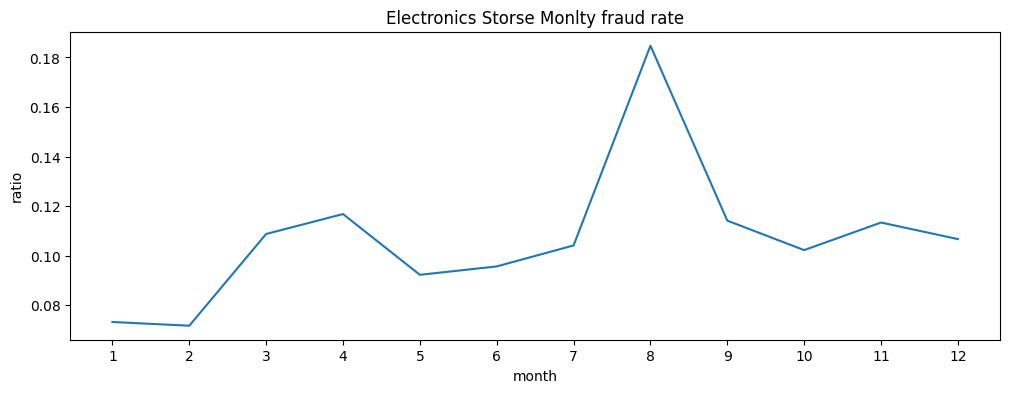

In [50]:
month = (
    ES
    .groupby("tx_month")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
month.plot()
plt.xticks(month.index)
plt.xlabel("month")
plt.ylabel("ratio")
plt.title("Electronics Storse Monlty fraud rate")
plt.show()

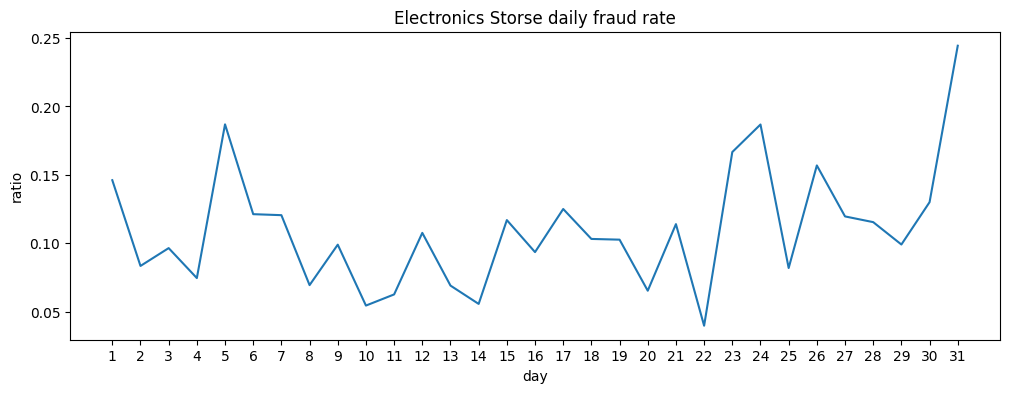

In [52]:
day = (
    ES
    .groupby("tx_day")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
day.plot()
plt.xticks(day.index)
plt.xlabel("day")
plt.ylabel("ratio")
plt.title("Electronics Storse daily fraud rate")
plt.show()

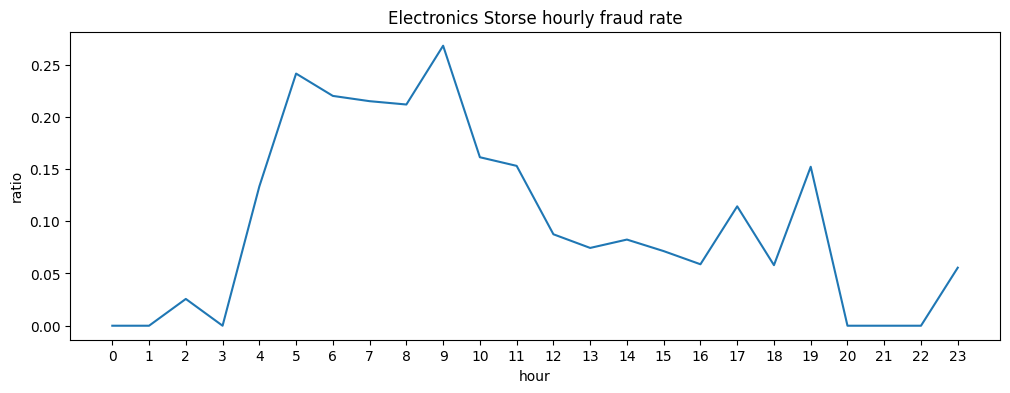

In [54]:
hour = (
    ES
    .groupby("tx_hour")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
hour.plot()
plt.xticks(hour.index)
plt.xlabel("hour")
plt.ylabel("ratio")
plt.title("Electronics Storse hourly fraud rate")
plt.show()

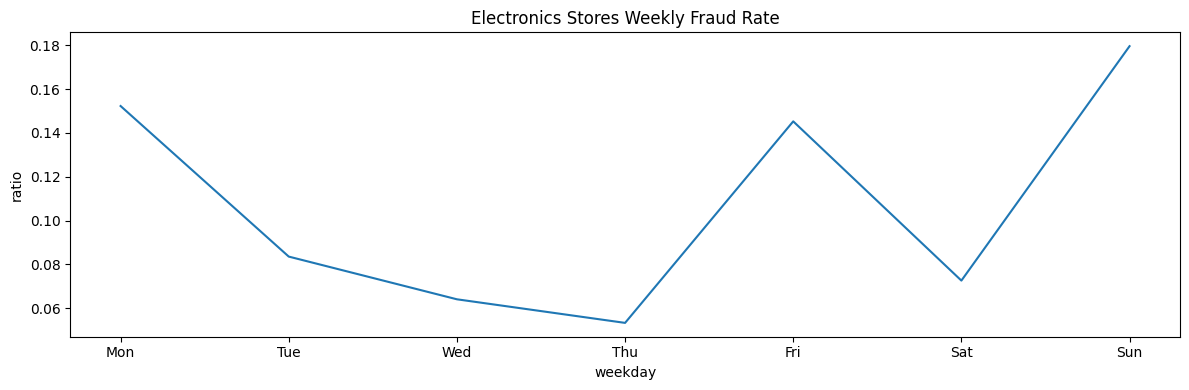

In [80]:
order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

week = (
    ES
    .groupby("weekday_name")[LABEL]
    .mean()
    .reindex(order)
)

plt.figure(figsize=(12,4))
ax = week.plot()

ax.set_xticks(range(len(week)))
ax.set_xticklabels(week.index, rotation=0)

plt.xlabel("weekday")
plt.ylabel("ratio")
plt.title("Electronics Stores Weekly Fraud Rate")
plt.tight_layout()
plt.show()


is_refund

In [88]:
refund = (
    ES
    .groupby("is_refund")[LABEL]
    .mean()
)
refund

is_refund
0    0.107561
Name: fraud, dtype: float64

log_abs_amount

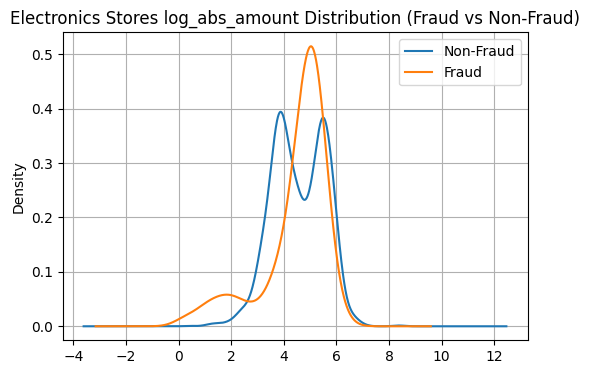

In [93]:
plt.figure(figsize=(6,4))
ES[ES["fraud"] == 0]["log_abs_amount"].plot(kind="kde", label="Non-Fraud")
ES[ES["fraud"] == 1]["log_abs_amount"].plot(kind="kde", label="Fraud")
plt.title(f"Electronics Stores log_abs_amount Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

is_credit / debit(prepaid) / debit

In [ ]:
ES.groupby("fraud")["is_credit"].mean()

fraud
0    0.403739
1    0.316832
Name: is_credit, dtype: float64

In [104]:
ES.groupby("fraud")["is_prepaid"].mean()

fraud
0    0.043357
1    0.118812
Name: is_prepaid, dtype: float64

대다수 fraud는 prepaid되지 않은 체크카드 _ 다중공선성 문제 있을까봐 is_depit(non prepaid)는 컬럼에 없음 주의

**5045_Computers, Computer Peripheral Equipment**\
When) 3월, 25일, 아침

In [55]:
C = df[df["mcc"]=="5045"].copy()

When

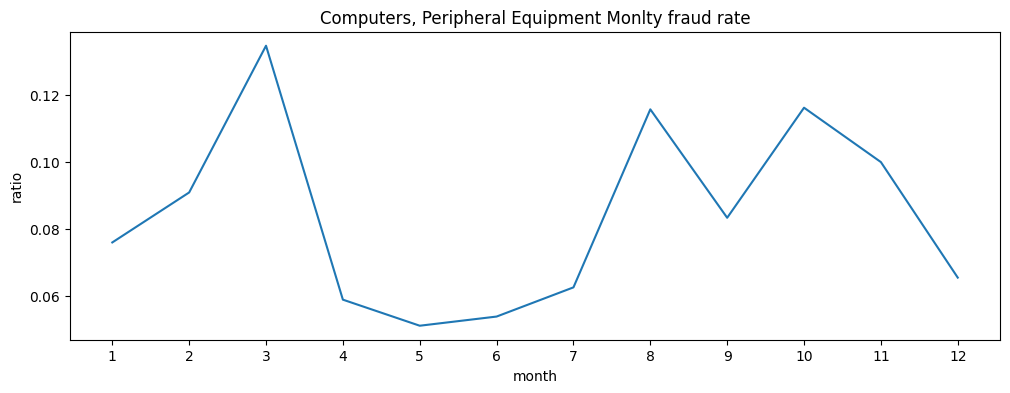

In [59]:
month = (
    C
    .groupby("tx_month")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
month.plot()
plt.xticks(month.index)
plt.xlabel("month")
plt.ylabel("ratio")
plt.title("Computers, Peripheral Equipment Monlty fraud rate")
plt.show()

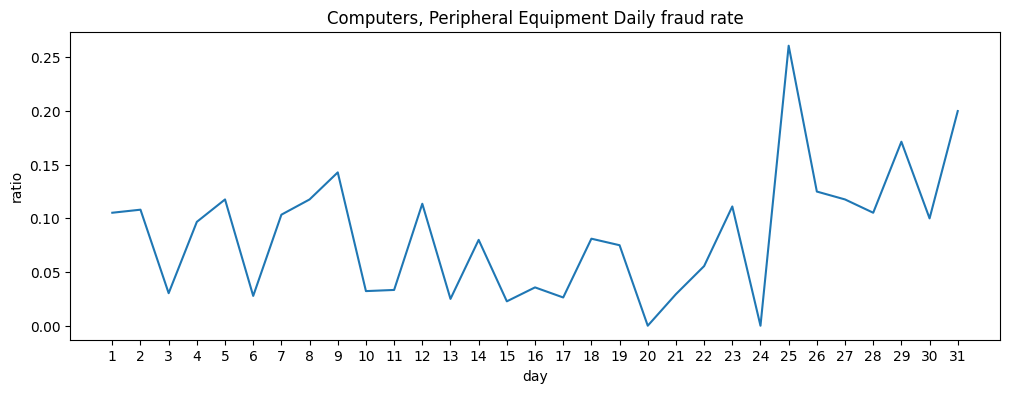

In [72]:
day = (
    C
    .groupby("tx_day")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
day.plot()
plt.xticks(day.index)
plt.xlabel("day")
plt.ylabel("ratio")
plt.title("Computers, Peripheral Equipment Daily fraud rate")
plt.show()

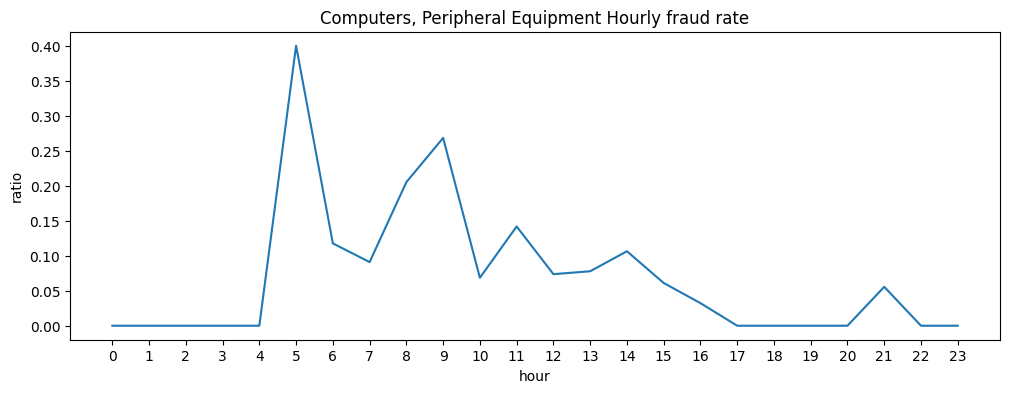

In [73]:
hour = (
    C
    .groupby("tx_hour")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
hour.plot()
plt.xticks(hour.index)
plt.xlabel("hour")
plt.ylabel("ratio")
plt.title("Computers, Peripheral Equipment Hourly fraud rate")
plt.show()

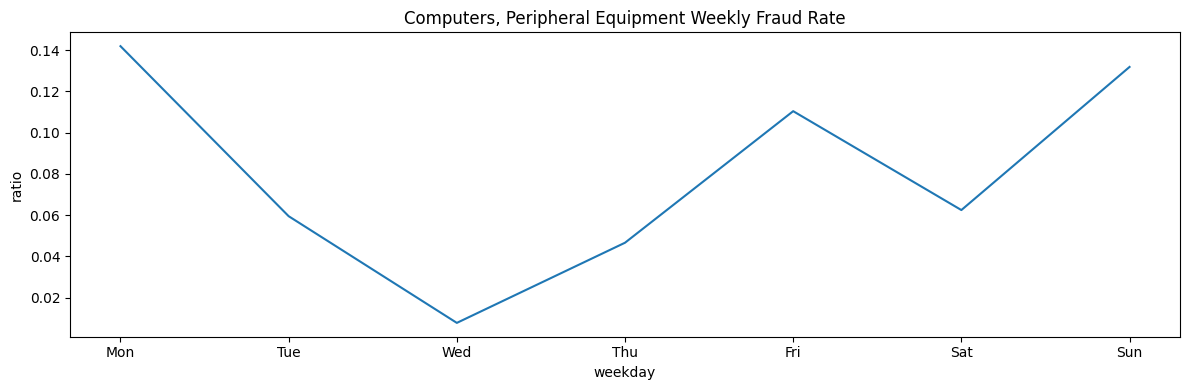

In [82]:
week = (
    C
    .groupby("weekday_name")[LABEL]
    .mean()
    .reindex(order)
)

plt.figure(figsize=(12,4))
ax = week.plot()

ax.set_xticks(range(len(week)))
ax.set_xticklabels(week.index, rotation=0)

plt.xlabel("weekday")
plt.ylabel("ratio")
plt.title("Computers, Peripheral Equipment Weekly Fraud Rate")
plt.tight_layout()
plt.show()

is_refund

In [89]:
refund = (
    C
    .groupby("is_refund")[LABEL]
    .mean()
)
refund

is_refund
0    0.083486
Name: fraud, dtype: float64

log_abs_amount

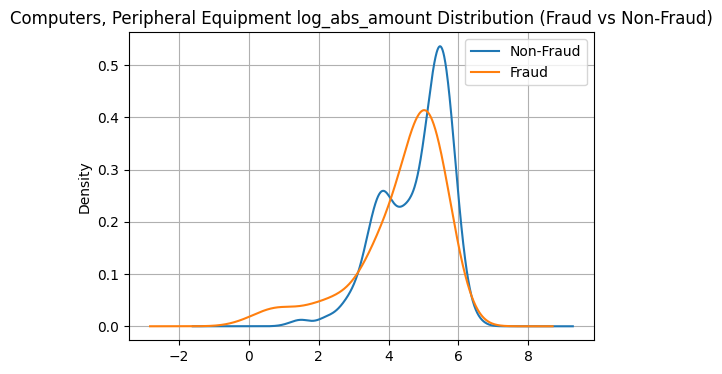

In [94]:
plt.figure(figsize=(6,4))
C[C["fraud"] == 0]["log_abs_amount"].plot(kind="kde", label="Non-Fraud")
C[C["fraud"] == 1]["log_abs_amount"].plot(kind="kde", label="Fraud")
plt.title(f"Computers, Peripheral Equipment log_abs_amount Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

is_credit / debit(prepaid) / debit

In [105]:
C.groupby("fraud")["is_credit"].mean()

fraud
0    0.437437
1    0.274725
Name: is_credit, dtype: float64

In [106]:
C.groupby("fraud")["is_prepaid"].mean()

fraud
0    0.027027
1    0.109890
Name: is_prepaid, dtype: float64

대다수 fraud는 prepaid되지 않은 체크카드

**5816_Digital Goods - Games**\
When) 7월, 1_, 새벽

In [56]:
DG = df[df["mcc"]=="5816"].copy()

When

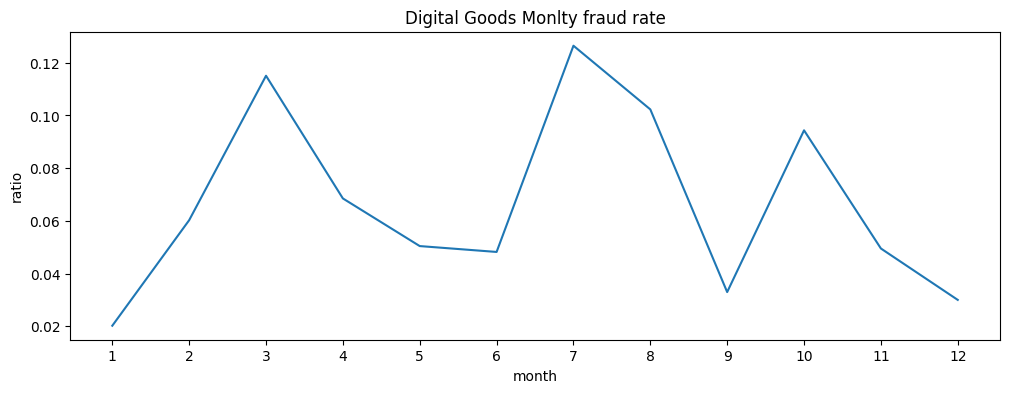

In [60]:
month = (
    DG
    .groupby("tx_month")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
month.plot()
plt.xticks(month.index)
plt.xlabel("month")
plt.ylabel("ratio")
plt.title("Digital Goods Monlty fraud rate")
plt.show()

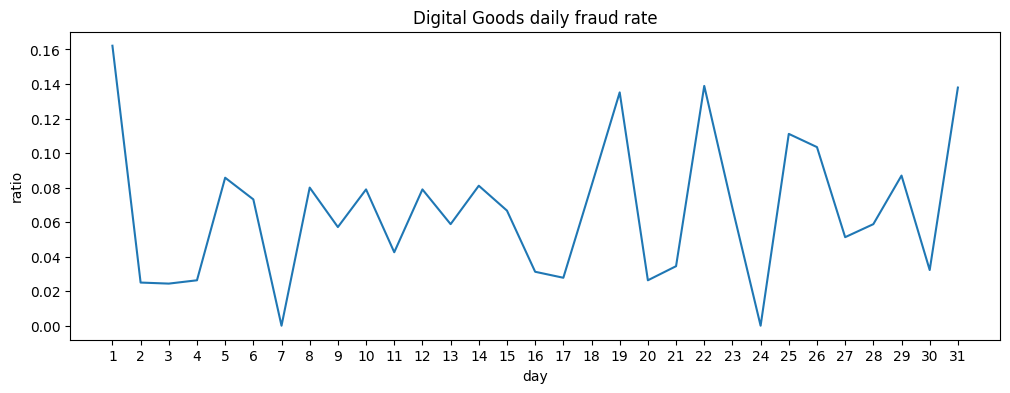

In [70]:
day = (
    DG
    .groupby("tx_day")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
day.plot()
plt.xticks(day.index)
plt.xlabel("day")
plt.ylabel("ratio")
plt.title("Digital Goods daily fraud rate")
plt.show()

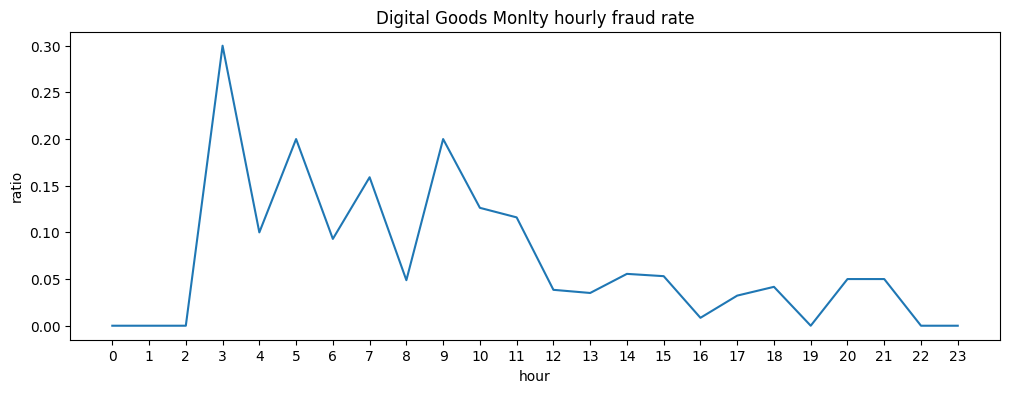

In [71]:
hour = (
    DG
    .groupby("tx_hour")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
hour.plot()
plt.xticks(hour.index)
plt.xlabel("hour")
plt.ylabel("ratio")
plt.title("Digital Goods Monlty hourly fraud rate")
plt.show()

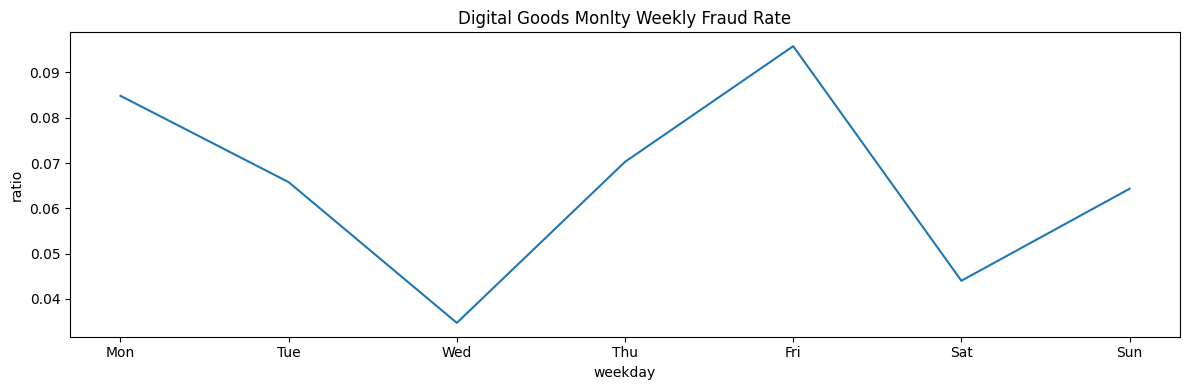

In [83]:
week = (
    DG
    .groupby("weekday_name")[LABEL]
    .mean()
    .reindex(order)
)

plt.figure(figsize=(12,4))
ax = week.plot()

ax.set_xticks(range(len(week)))
ax.set_xticklabels(week.index, rotation=0)

plt.xlabel("weekday")
plt.ylabel("ratio")
plt.title("Digital Goods Monlty Weekly Fraud Rate")
plt.tight_layout()
plt.show()

is_refund

In [90]:
refund = (
    DG
    .groupby("is_refund")[LABEL]
    .mean()
)
refund

is_refund
0    0.066492
Name: fraud, dtype: float64

log_abs_amount

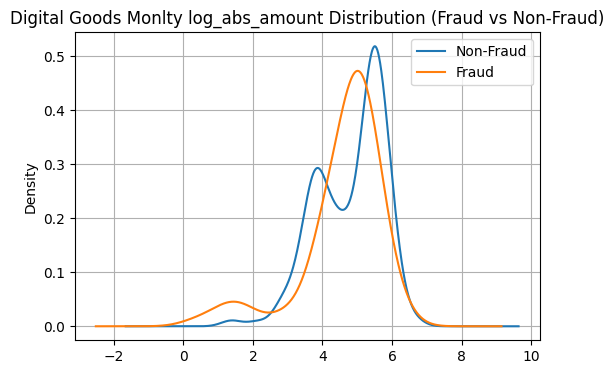

In [95]:
plt.figure(figsize=(6,4))
DG[DG["fraud"] == 0]["log_abs_amount"].plot(kind="kde", label="Non-Fraud")
DG[DG["fraud"] == 1]["log_abs_amount"].plot(kind="kde", label="Fraud")
plt.title(f"Digital Goods Monlty log_abs_amount Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

is_credit / debit(prepaid) / debit

In [107]:
DG.groupby("fraud")["is_credit"].mean()

fraud
0    0.447048
1    0.315789
Name: is_credit, dtype: float64

In [108]:
DG.groupby("fraud")["is_prepaid"].mean()

fraud
0    0.022493
1    0.078947
Name: is_prepaid, dtype: float64

대다수 fraud는 prepaid되지 않은 체크카드

**5094_Precious Stones and Metals**\
When) 5,12월, 23일, 새벽~오전

In [57]:
SM = df[df["mcc"]=="5094"].copy()

When

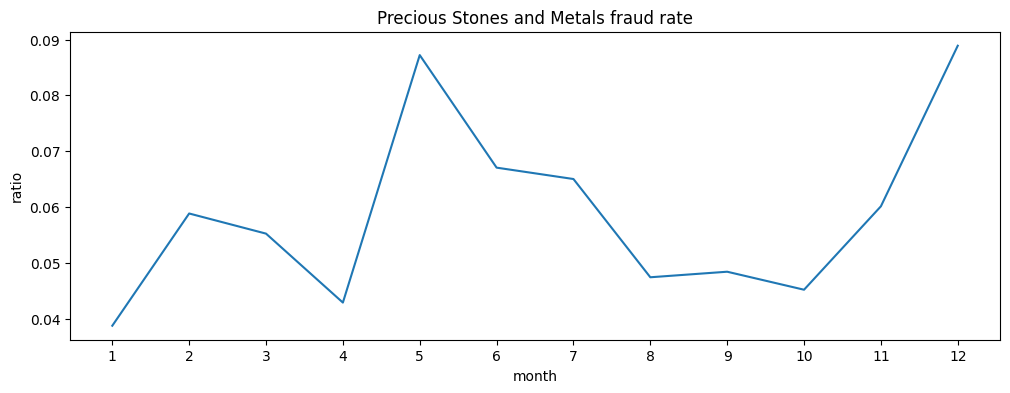

In [61]:
month = (
    SM
    .groupby("tx_month")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
month.plot()
plt.xticks(month.index)
plt.xlabel("month")
plt.ylabel("ratio")
plt.title("Precious Stones and Metals fraud rate")
plt.show()

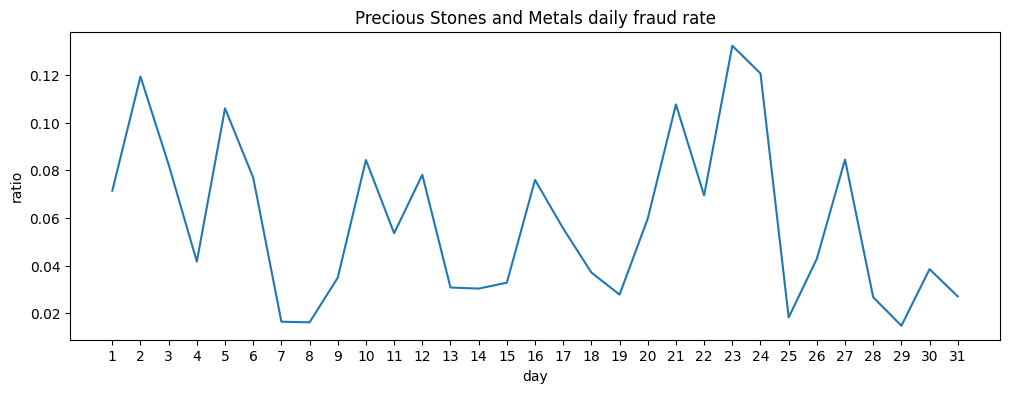

In [68]:
day = (
    SM
    .groupby("tx_day")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
day.plot()
plt.xticks(day.index)
plt.xlabel("day")
plt.ylabel("ratio")
plt.title("Precious Stones and Metals daily fraud rate")
plt.show()

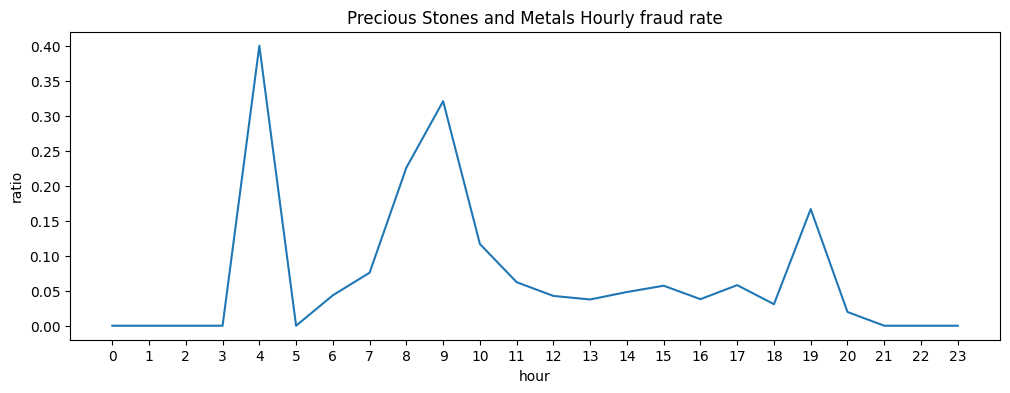

In [69]:
hour = (
    SM
    .groupby("tx_hour")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
hour.plot()
plt.xticks(hour.index)
plt.xlabel("hour")
plt.ylabel("ratio")
plt.title("Precious Stones and Metals Hourly fraud rate")
plt.show()

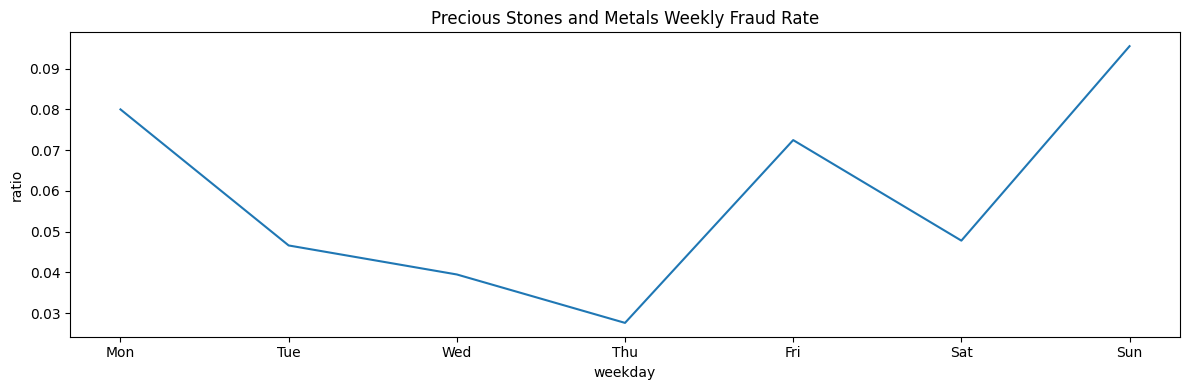

In [84]:
week = (
    SM
    .groupby("weekday_name")[LABEL]
    .mean()
    .reindex(order)
)

plt.figure(figsize=(12,4))
ax = week.plot()

ax.set_xticks(range(len(week)))
ax.set_xticklabels(week.index, rotation=0)

plt.xlabel("weekday")
plt.ylabel("ratio")
plt.title("Precious Stones and Metals Weekly Fraud Rate")
plt.tight_layout()
plt.show()

is_refund

In [91]:
refund = (
    SM
    .groupby("is_refund")[LABEL]
    .mean()
)
refund

is_refund
0    0.05922
Name: fraud, dtype: float64

log_abs_amount

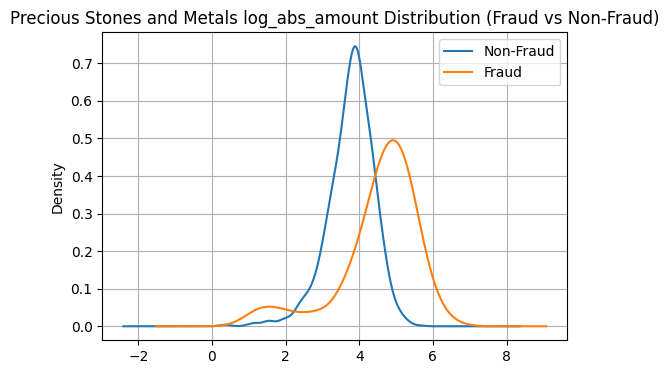

In [96]:
plt.figure(figsize=(6,4))
SM[SM["fraud"] == 0]["log_abs_amount"].plot(kind="kde", label="Non-Fraud")
SM[SM["fraud"] == 1]["log_abs_amount"].plot(kind="kde", label="Fraud")
plt.title(f"Precious Stones and Metals log_abs_amount Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

is_credit / debit(prepaid) / debit

In [109]:
SM.groupby("fraud")["is_credit"].mean()

fraud
0    0.360798
1    0.333333
Name: is_credit, dtype: float64

In [110]:
SM.groupby("fraud")["is_prepaid"].mean()

fraud
0    0.067042
1    0.178862
Name: is_prepaid, dtype: float64

대다수 fraud는 prepaid되지 않은 체크카드

**5712_Furniture, Home Furnishings, and Equipment Stores**\
When) 3월, 3일_, 1~3시

In [58]:
F = df[df["mcc"]=="5712"].copy()

When

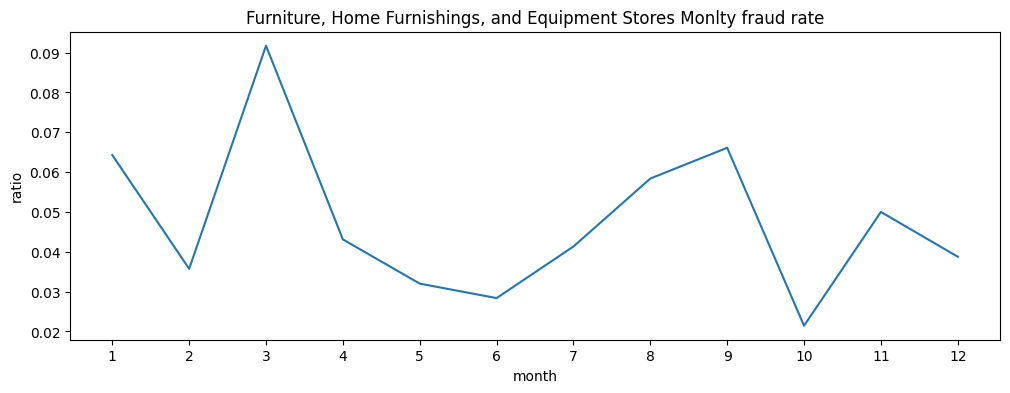

In [62]:
month = (
    F
    .groupby("tx_month")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
month.plot()
plt.xticks(month.index)
plt.xlabel("month")
plt.ylabel("ratio")
plt.title("Furniture, Home Furnishings, and Equipment Stores Monlty fraud rate")
plt.show()

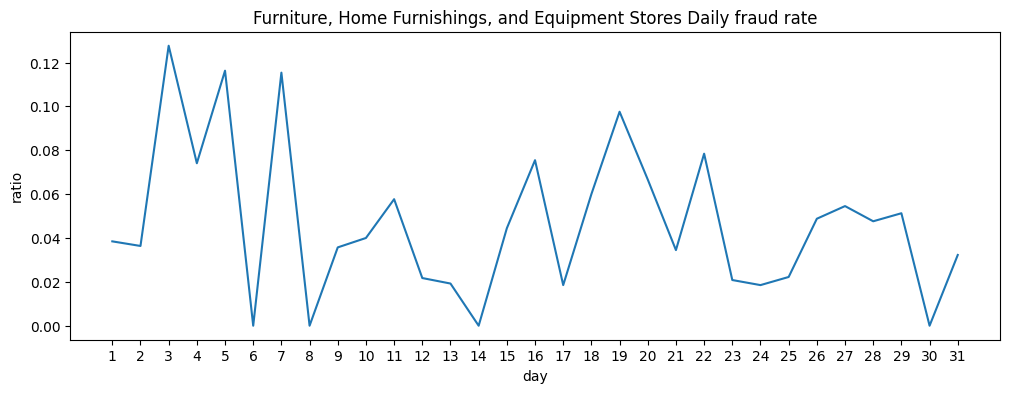

In [66]:
day = (
    F
    .groupby("tx_day")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
day.plot()
plt.xticks(day.index)
plt.xlabel("day")
plt.ylabel("ratio")
plt.title("Furniture, Home Furnishings, and Equipment Stores Daily fraud rate")
plt.show()

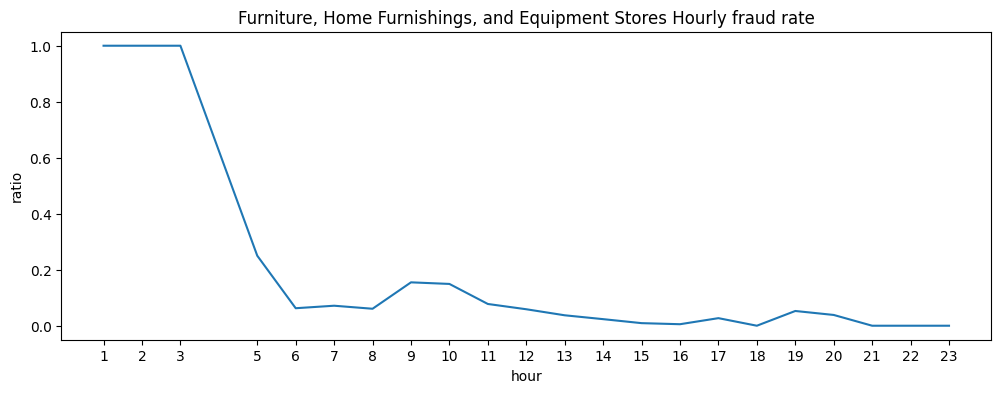

In [65]:
hour = (
    F
    .groupby("tx_hour")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
hour.plot()
plt.xticks(hour.index)
plt.xlabel("hour")
plt.ylabel("ratio")
plt.title("Furniture, Home Furnishings, and Equipment Stores Hourly fraud rate")
plt.show()

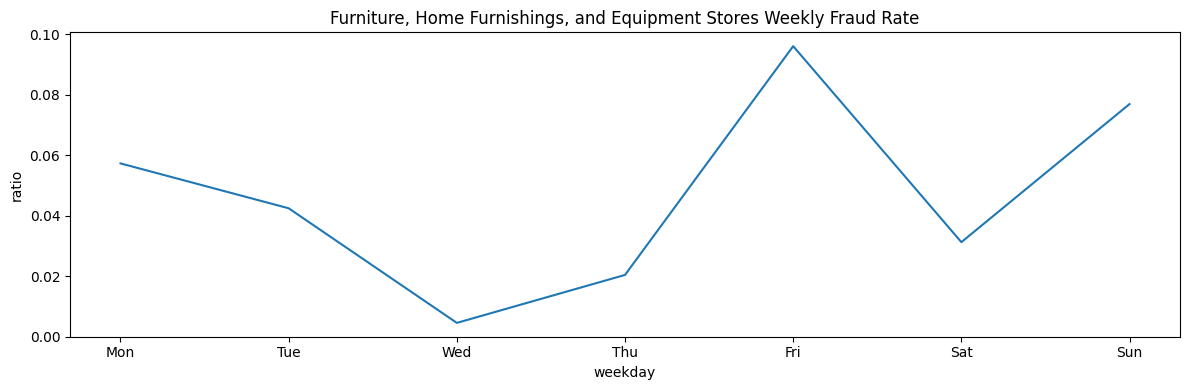

In [85]:
week = (
    F
    .groupby("weekday_name")[LABEL]
    .mean()
    .reindex(order)
)

plt.figure(figsize=(12,4))
ax = week.plot()

ax.set_xticks(range(len(week)))
ax.set_xticklabels(week.index, rotation=0)

plt.xlabel("weekday")
plt.ylabel("ratio")
plt.title("Furniture, Home Furnishings, and Equipment Stores Weekly Fraud Rate")
plt.tight_layout()
plt.show()

is_refund

In [92]:
refund = (
    F
    .groupby("is_refund")[LABEL]
    .mean()
)
refund

is_refund
0    0.046989
Name: fraud, dtype: float64

log_abs_amount

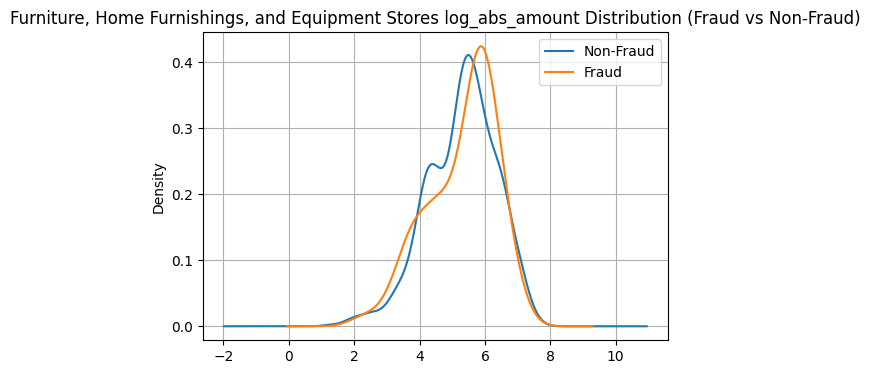

In [97]:
plt.figure(figsize=(6,4))
F[F["fraud"] == 0]["log_abs_amount"].plot(kind="kde", label="Non-Fraud")
F[F["fraud"] == 1]["log_abs_amount"].plot(kind="kde", label="Fraud")
plt.title(f"Furniture, Home Furnishings, and Equipment Stores log_abs_amount Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

is_credit / debit(prepaid) / debit

In [111]:
F.groupby("fraud")["is_credit"].mean()

fraud
0    0.463194
1    0.281690
Name: is_credit, dtype: float64

In [112]:
F.groupby("fraud")["is_prepaid"].mean()

fraud
0    0.020139
1    0.070423
Name: is_prepaid, dtype: float64

대다수 fraud는 prepaid되지 않은 체크카드

> “주요 MCC 대부분 아침 시간대에 주로 발생”\
> → 노트북의 MCC별 tx_hour fraud rate 그래프 + “When 메모(아침/새벽~오전)”가 그 방향으로 정리돼 있음.

> “요일은 대부분 금·일 피크”\
> → MCC별 weekday_name fraud rate도 동일 템플릿으로 확인하는 구조라서, “전역 요일 패턴이 MCC별로도 유지되는지”를 재확인한 셈.

> “fraud는 debit(non_prepaid)가 가장 높다”\
> → MCC 5개 전부에서 fraud의 is_credit 평균이 낮아지고, prepaid는 오르긴 하지만 절대값이 크지 않아서 최종적으로 non-prepaid debit 쏠림 결론이 일관됨.

| 항목          | 유의미성 |
| ----------- | ---- |
| 아침 fraud 집중 | 중간   |
| 금·일 피크      | 중간   |
| debit 우세    | 약~중간 |
| MCC별 일관성    | 흥미로움 |


### **환불 구조**

In [129]:
df.groupby("is_refund")[LABEL].mean()

is_refund
0    0.001460
1    0.001194
Name: fraud, dtype: float64

In [131]:
df.groupby("fraud")["is_refund"].mean()

fraud
0    0.050126
1    0.041363
Name: is_refund, dtype: float64

refund & fraud 거래의 amount 분포

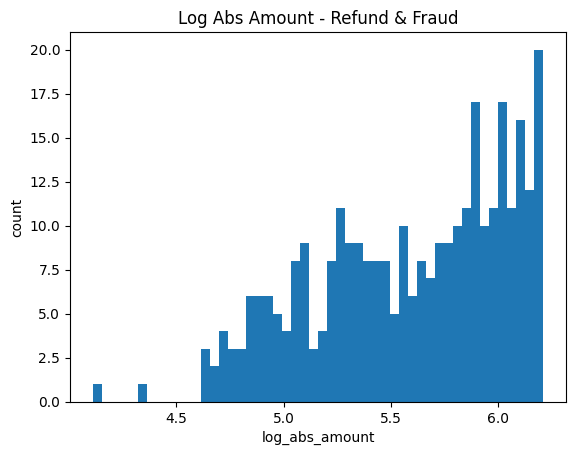

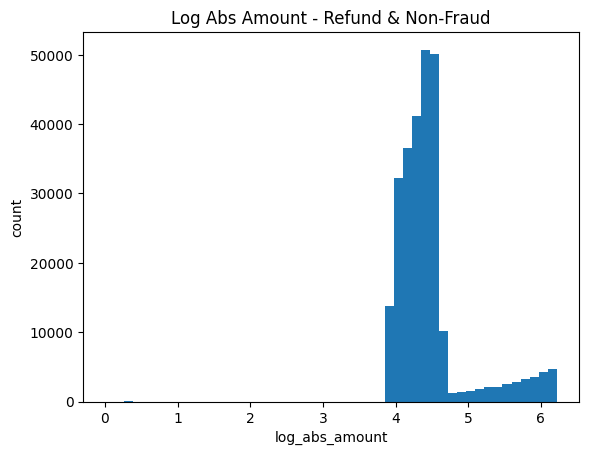

Mean amount (refund+fraud): -293.47485
Mean amount (refund+nonfraud): -102.138275


In [132]:
df_rf = df[(df["is_refund"] == 1) & (df["fraud"] == 1)]
df_rn = df[(df["is_refund"] == 1) & (df["fraud"] == 0)]

plt.figure()
plt.hist(np.log1p(np.abs(df_rf["amount"])), bins=50)
plt.title("Log Abs Amount - Refund & Fraud")
plt.xlabel("log_abs_amount")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(np.log1p(np.abs(df_rn["amount"])), bins=50)
plt.title("Log Abs Amount - Refund & Non-Fraud")
plt.xlabel("log_abs_amount")
plt.ylabel("count")
plt.show()

print("Mean amount (refund+fraud):", df_rf["amount"].mean())
print("Mean amount (refund+nonfraud):", df_rn["amount"].mean())

> refund & fraud는 고금액 쪽에 몰려 있음

refund가 가장 잘 일어나는 품목

In [133]:
refund = df[df["is_refund"]==1]

In [138]:
refund_mcc_table = (
    refund
    .groupby(["mcc", "fraud"])
    .size()
    .unstack(fill_value=0)
)

refund_mcc_table["total"] = refund_mcc_table.sum(axis=1)
refund_mcc_table["fraud_rate"] = (
    refund_mcc_table[1] / refund_mcc_table["total"]
)

refund_mcc_table.sort_values("fraud_rate", ascending=False)


fraud,0,1,total,fraud_rate
mcc,,,,
3405,951,17,968,0.017562
3387,1071,18,1089,0.016529
3596,1802,24,1826,0.013143
3390,1041,13,1054,0.012334
3771,1782,22,1804,0.012195
3504,1956,24,1980,0.012121
3722,1927,21,1948,0.010780
3509,1966,21,1987,0.010569
3730,1794,19,1813,0.010480


이 merchant는 과거에 refund가 얼마나 자주 발생했는가? 등으로 활용해야 할 듯\
fraud가 직접적인 신호 역할이 되지는 못함

### **카드 유형**

credit / debit(prepaid) / debit(non_prepaid)

In [3]:
df["card_type"] = np.select(
    [
        df["is_credit"] == 1,
        df["is_prepaid"] == 1
    ],
    [
        "credit",
        "debit(prepaid)"
    ],
    default="debit(non_prepaid)"
)

In [4]:
df["card_type"] = df["card_type"].astype("category")

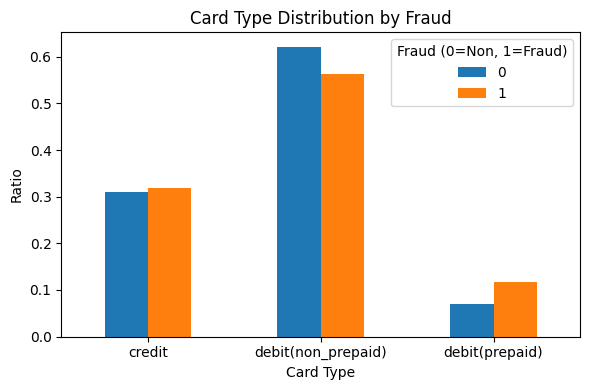

In [14]:
card_ratio = (
    df.groupby("fraud")["card_type"]
      .value_counts(normalize=True)
      .unstack()
)

card_ratio.T.plot(kind="bar", figsize=(6,4))
plt.ylabel("Ratio")
plt.xlabel("Card Type")
plt.title("Card Type Distribution by Fraud")
plt.xticks(rotation=0)
plt.legend(title="Fraud (0=Non, 1=Fraud)")
plt.tight_layout()
plt.show()


In [15]:
fraud_rate = (
    df.groupby("card_type")["fraud"]
      .mean()
      .sort_values(ascending=False)
)
fraud_rate

/tmp/ipykernel_3527018/1246485000.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("card_type")["fraud"]


card_type
debit(prepaid)        0.002438
credit                0.001494
debit(non_prepaid)    0.001313
Name: fraud, dtype: float64

In [146]:
fraud_rate

card_type
credit                0.001494
debit(non_prepaid)    0.001313
debit(prepaid)        0.002438
Name: fraud, dtype: float64

**왜 prepaid가 더 높을까**

amount x prepaid

Text(0, 0.5, '')

/home/nakyung/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


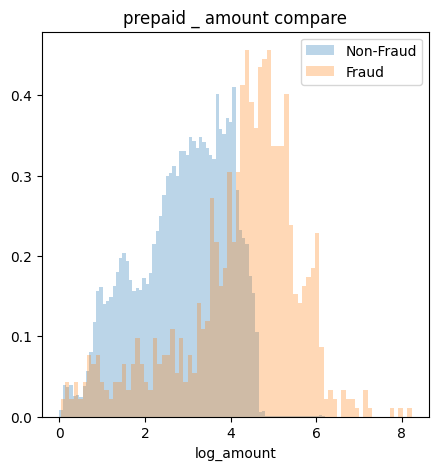

In [23]:
prepaid = df[df["card_type"]=="debit(prepaid)"].copy()

plt.figure(figsize=(5,5))
plt.hist(prepaid[prepaid["fraud"]==0]["log_abs_amount"], bins=80, density=True, alpha=0.3, label="Non-Fraud")
plt.hist(prepaid[prepaid["fraud"]==1]["log_abs_amount"], bins=80, density=True, alpha=0.3, label="Fraud")
plt.xlabel("log_amount")
plt.title("prepaid _ amount compare")
plt.legend()
plt.ylabel("")

In [30]:
prepaid["log_abs_amount"].describe()

count    368352.000000
mean          2.868211
std           1.075478
min           0.000000
25%           2.124654
50%           3.013572
75%           3.741472
max           8.229938
Name: log_abs_amount, dtype: float64

mcc x prepaid

In [24]:
prepaid = df[df["card_type"] == "debit(prepaid)"].copy()

mcc_compare = (
    prepaid.groupby(["mcc", "fraud"])
           .size()
           .unstack(fill_value=0)
)

mcc_compare_ratio = mcc_compare.div(mcc_compare.sum(axis=1), axis=0)

mcc_compare_ratio.head()

fraud,0,1
mcc,,
1711,1.000000,0.000000
3000,0.166667,0.833333
3001,0.500000,0.500000
3005,0.000000,1.000000
3006,0.333333,0.666667


In [25]:
mcc_compare_ratio = mcc_compare_ratio.sort_values(by=1, ascending=False)

In [28]:
mcc_compare["total"] = mcc_compare.sum(axis=1)

mcc_filtered = mcc_compare[mcc_compare["total"] >= 50]

mcc_ratio = (
    mcc_filtered[[0,1]]
    .div(mcc_filtered["total"], axis=0)
    .sort_values(by=1, ascending=False)
)

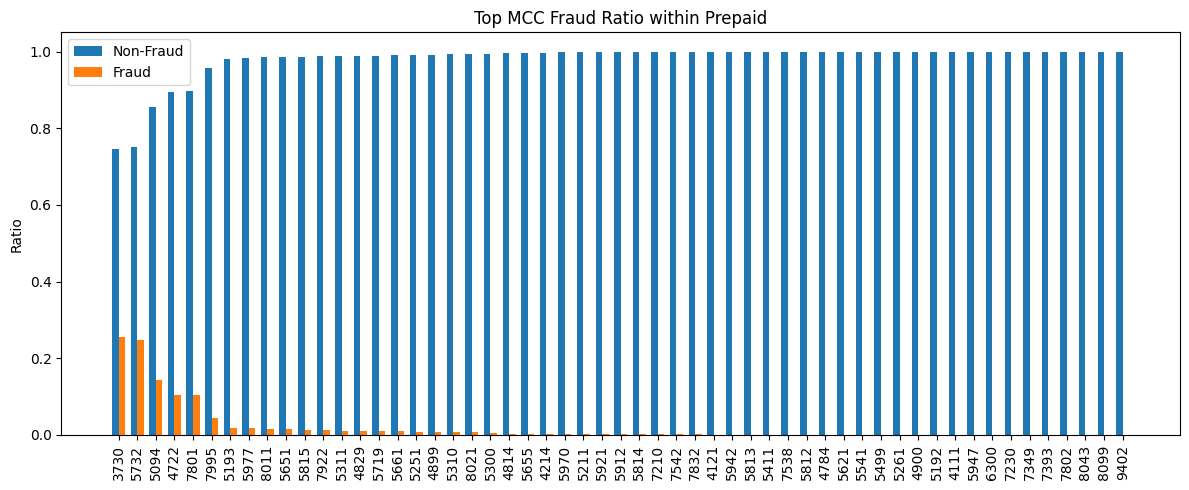

In [29]:
x = np.arange(len(mcc_ratio))
width = 0.35

plt.figure(figsize=(12,5))
plt.bar(x - width/2, mcc_ratio[0], width, label="Non-Fraud")
plt.bar(x + width/2, mcc_ratio[1], width, label="Fraud")

plt.xticks(x, mcc_ratio.index, rotation=90)
plt.ylabel("Ratio")
plt.title("Top MCC Fraud Ratio within Prepaid")
plt.legend()
plt.tight_layout()
plt.show()

3730: Ship Chandlers\
5732: Electronics Stores\
5094: Precious Stones and Metals\
4722: Travel Agencies\
7801: Athletic Fields, Commercial Sports

3730	0.005768	0.009177	0.254902\
5732    0.086409	0.109545	0.248276\
5094	0.054960	0.050934	0.143791\
4722	0.007335	0.011815	0.105263\
7801	0.008553	0.008223	0.103093

In [40]:
mcc_pivot = (
    df.groupby(["mcc", "card_type"])["fraud"]
      .mean()
      .unstack() 
)

mcc_pivot.sort_values(by="debit(prepaid)", ascending=False)

/tmp/ipykernel_3527018/2560251450.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["mcc", "card_type"])["fraud"]


card_type,credit,debit(non_prepaid),debit(prepaid)
mcc,,,
3008,0.032258,0.086957,1.000000
3007,0.054054,0.070588,1.000000
3005,0.085714,0.052632,1.000000
4411,0.486111,0.719626,1.000000
5733,0.269841,0.477612,1.000000
3000,0.013661,0.031079,0.833333
3256,0.003106,0.017204,0.800000
3058,0.005175,0.018443,0.750000
3006,0.117647,0.142857,0.666667


In [41]:
high_risk_mcc = [3730, 5732, 5094, 4722, 7801]

df["prepaid_highrisk_flag"] = (
    (df["card_type"] == "debit(prepaid)") &
    (df["mcc"].isin(high_risk_mcc))
).astype(int)

In [43]:
df["mcc"] = df["mcc"].astype(int)

for m in high_risk_mcc:
    sub = df[df["mcc"] == m]
    print(m, sub.groupby("card_type")["fraud"].mean())


/tmp/ipykernel_3527018/2866644624.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(m, sub.groupby("card_type")["fraud"].mean())


3730 card_type
credit                0.005768
debit(non_prepaid)    0.009177
debit(prepaid)        0.254902
Name: fraud, dtype: float64
5732 card_type
credit                0.086409
debit(non_prepaid)    0.109545
debit(prepaid)        0.248276
Name: fraud, dtype: float64
5094 card_type
credit                0.054960
debit(non_prepaid)    0.050934
debit(prepaid)        0.143791
Name: fraud, dtype: float64
4722 card_type
credit                0.007335
debit(non_prepaid)    0.011815
debit(prepaid)        0.105263
Name: fraud, dtype: float64
7801 card_type
credit                0.008553
debit(non_prepaid)    0.008223
debit(prepaid)        0.103093
Name: fraud, dtype: float64


In [44]:
for m in [3730,5732,5094,4722,7801]:
    sub = df[df["mcc"] == m]
    print(m)
    print(sub["card_type"].value_counts())
    print()


3730
card_type
debit(non_prepaid)    2942
credit                2774
debit(prepaid)          51
Name: count, dtype: int64

5732
card_type
debit(non_prepaid)    1561
credit                1111
debit(prepaid)         145
Name: count, dtype: int64

5094
card_type
debit(non_prepaid)    1178
credit                 746
debit(prepaid)         153
Name: count, dtype: int64

4722
card_type
debit(non_prepaid)    6517
credit                6271
debit(prepaid)          76
Name: count, dtype: int64

7801
card_type
debit(non_prepaid)    4013
credit                2923
debit(prepaid)          97
Name: count, dtype: int64



In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5312525 entries, 0 to 5332978
Data columns (total 48 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   date                      datetime64[ns]
 1   client_id                 int64         
 2   card_id                   int64         
 3   amount                    float32       
 4   merchant_id               int64         
 5   mcc                       object        
 6   fraud                     int8          
 7   has_error                 int8          
 8   err_bad_card_number       int8          
 9   err_bad_expiration        int8          
 10  err_bad_cvv               int8          
 11  err_bad_pin               int8          
 12  err_bad_zipcode           int8          
 13  err_insufficient_balance  int8          
 14  err_technical_glitch      int8          
 15  tx_year                   int16         
 16  tx_month                  int8          
 17  tx_day       

cb_Visa           

cb_Mastercard         

cb_Amex            
 
cb_Discover      

In [73]:
df["card_brand"] = np.select([
    df["cb_Visa"] == 1,
    df["cb_Mastercard"] == 1,
    df["cb_Amex"] == 1,
],
[
    "visa",
    "mastercard",
    "amex",
],
    default="discover"
)

In [79]:
non = df[df["fraud"]==0].copy()

In [80]:
fraud = df[df["fraud"]==1].copy()

In [82]:
p = (
    df.groupby(["card_brand", "fraud"])
      .size()
      .groupby(level=0)
      .apply(lambda x: x / x.sum())
      .unstack()
)
p

,fraud,0,1
card_brand,card_brand,,
amex,amex,0.998331,0.001669
discover,discover,0.997818,0.002182
mastercard,mastercard,0.998532,0.001468
visa,visa,0.998670,0.001330


In [83]:
non["card_brand"].value_counts()

card_brand
mastercard    2846632
visa          1981049
amex           346838
discover       130318
Name: count, dtype: int64

In [84]:
fraud["card_brand"].value_counts()

card_brand
mastercard    4184
visa          2639
amex           580
discover       285
Name: count, dtype: int64

In [85]:
results = []

for col in ["cb_Visa",
            "cb_Mastercard",
            "cb_Amex",
            "cb_Discover"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])


,feature,coef,OR,p_value
0,cb_Visa,-0.131312,0.876945,4.686713e-08
1,cb_Mastercard,0.030657,1.031132,1.809597e-01
2,cb_Amex,0.153952,1.166434,3.678975e-04
3,cb_Discover,0.424373,1.528631,2.177581e-12


### **(E) ERROR**

 8   err_bad_card_number       int8          
 9   err_bad_expiration        int8          
 10  err_bad_cvv               int8          
 11  err_bad_pin               int8          
 12  err_bad_zipcode           int8          
 13  err_insufficient_balance  int8          
 14  err_technical_glitch      int8 

In [86]:
err_cols = [
    "err_bad_card_number",
    "err_bad_expiration",
    "err_bad_cvv",
    "err_bad_pin",
    "err_bad_zipcode",
    "err_insufficient_balance",
    "err_technical_glitch"
]

err_ratio = (
    df.groupby("fraud")[err_cols]
      .mean()
      .T
)

err_ratio


fraud,0,1
err_bad_card_number,0.000585,0.005983
err_bad_expiration,0.000462,0.004683
err_bad_cvv,0.000442,0.013918
err_bad_pin,0.002445,0.003772
err_bad_zipcode,0.000089,0.000000
err_insufficient_balance,0.009916,0.013528
err_technical_glitch,0.002011,0.002732


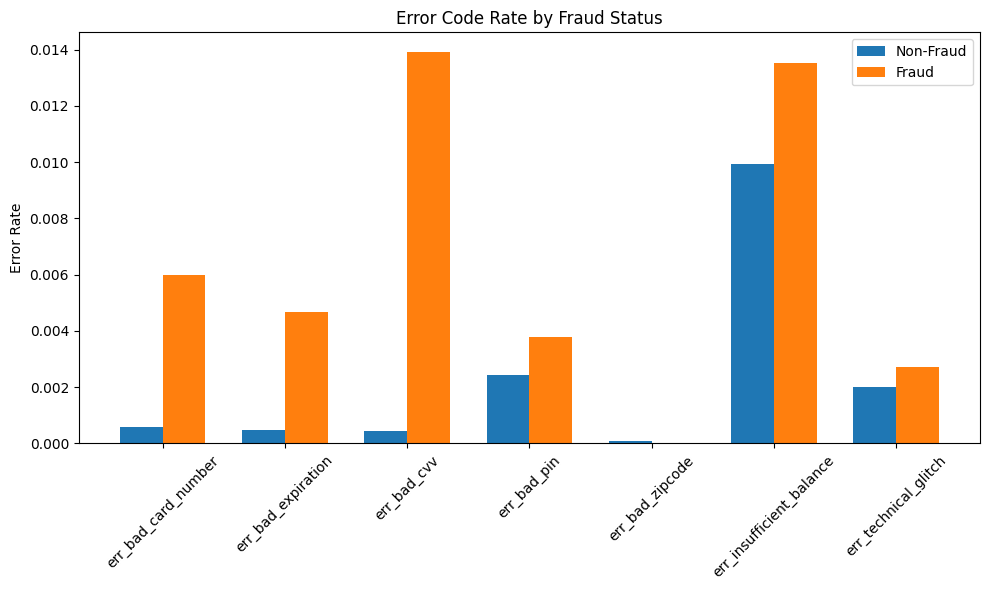

In [87]:
x = np.arange(len(err_cols))
width = 0.35

plt.figure(figsize=(10,6))

plt.bar(x - width/2, err_ratio[0], width, label="Non-Fraud")
plt.bar(x + width/2, err_ratio[1], width, label="Fraud")

plt.xticks(x, err_ratio.index, rotation=45)
plt.ylabel("Error Rate")
plt.title("Error Code Rate by Fraud Status")
plt.legend()
plt.tight_layout()
plt.show()

In [89]:
df.groupby("has_error")["fraud"].value_counts()

has_error  fraud
0          0        5220606
           1           7349
1          0          84231
           1            339
Name: count, dtype: int64

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5312525 entries, 0 to 5332978
Data columns (total 50 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   date                      datetime64[ns]
 1   client_id                 int64         
 2   card_id                   int64         
 3   amount                    float32       
 4   merchant_id               int64         
 5   mcc                       object        
 6   fraud                     int8          
 7   has_error                 int8          
 8   err_bad_card_number       int8          
 9   err_bad_expiration        int8          
 10  err_bad_cvv               int8          
 11  err_bad_pin               int8          
 12  err_bad_zipcode           int8          
 13  err_insufficient_balance  int8          
 14  err_technical_glitch      int8          
 15  tx_year                   int16         
 16  tx_month                  int8          
 17  tx_day       

In [ ]:
error_ratio = (
    df
    .groupby("has_error")["fraud"]
    .mean()
)

In [ ]:

plt.figure(figsize=(5,5))
error_ratio.plot()
plt.xlabel("has_error")
plt.ylabel("")

# 3️⃣ User / Client-Level

👉 이 사람은 어떤 사람인가?


**프로파일 축**

yearly_income

credit_score

total_debt

credit_limit

num_credit_cards

months_from_account

years_since_pin_change

current_age

male


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5312711 entries, 0 to 5332978
Data columns (total 51 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   date                      datetime64[ns]
 1   client_id                 int64         
 2   card_id                   int64         
 3   amount                    float32       
 4   merchant_id               int64         
 5   mcc                       int64         
 6   fraud                     int8          
 7   has_error                 int8          
 8   err_bad_card_number       int8          
 9   err_bad_expiration        int8          
 10  err_bad_cvv               int8          
 11  err_bad_pin               int8          
 12  err_bad_zipcode           int8          
 13  err_insufficient_balance  int8          
 14  err_technical_glitch      int8          
 15  tx_year                   int16         
 16  tx_month                  int8          
 17  tx_day       

yearly_income

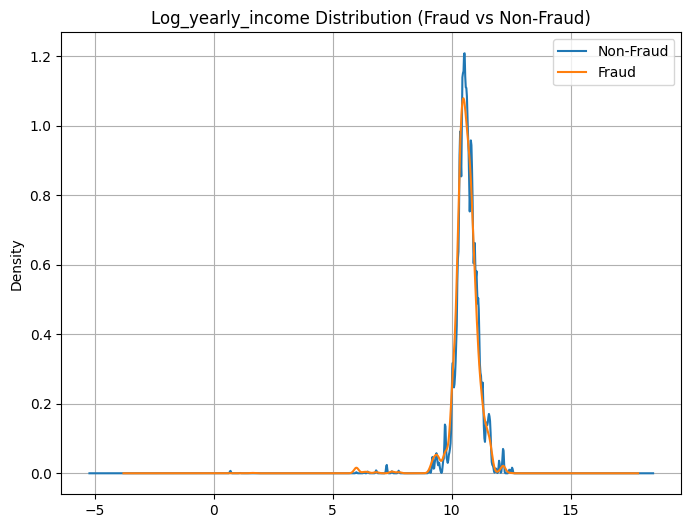

In [47]:
plt.figure(figsize=(8,6))
df[df["fraud"]==0]["log_yearly_income"].plot(kind="kde", label="Non-Fraud")
df[df["fraud"]==1]["log_yearly_income"].plot(kind="kde", label="Fraud")
plt.title("Log_yearly_income Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

credit_score

In [48]:
df["credit_score"].describe()

count    5.312711e+06
mean     7.139091e+02
std      6.588517e+01
min      4.880000e+02
25%      6.840000e+02
50%      7.160000e+02
75%      7.560000e+02
max      8.500000e+02
Name: credit_score, dtype: float64

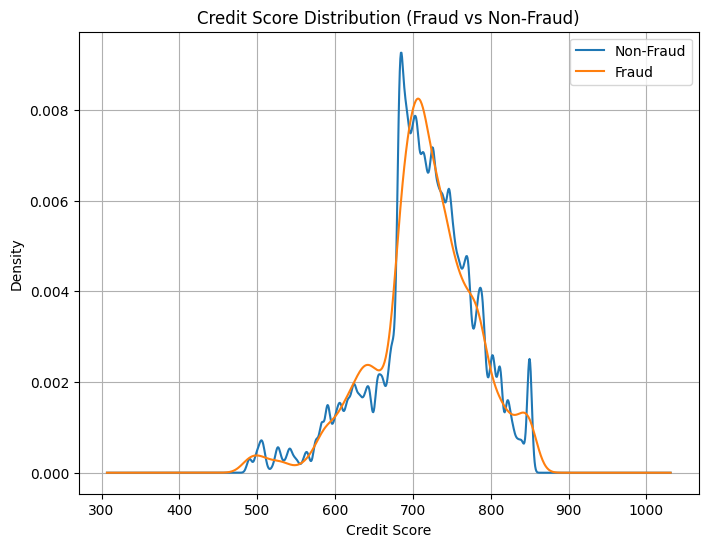

In [56]:
plt.figure(figsize=(8,6))

df[df["fraud"]==0]["credit_score"].plot(
    kind="kde", label="Non-Fraud"
)
df[df["fraud"]==1]["credit_score"].plot(
    kind="kde", label="Fraud"
)

plt.title("Credit Score Distribution (Fraud vs Non-Fraud)")
plt.xlabel("Credit Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


total_debt

In [4]:
df["total_debt"].describe()

count    5.312711e+06
mean     5.798944e+04
std      5.194886e+04
min      0.000000e+00
25%      1.652400e+04
50%      5.167900e+04
75%      8.516000e+04
max      4.618540e+05
Name: total_debt, dtype: float64

In [6]:
non = df[df["fraud"]==0].copy()
fraud = df[df["fraud"]==1].copy()

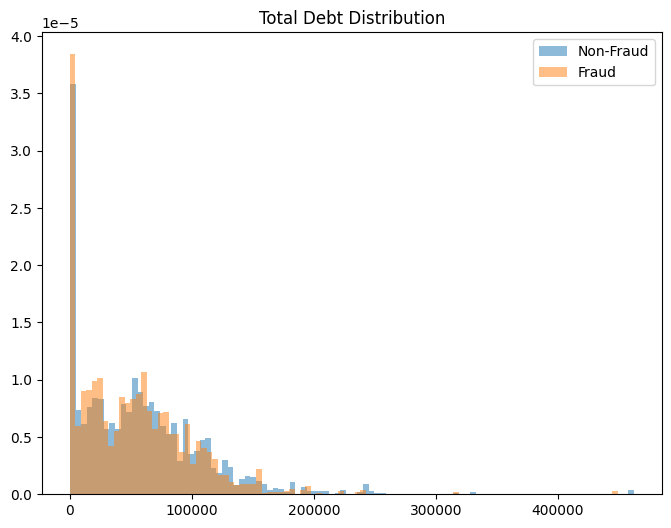

In [5]:
plt.figure(figsize=(8,6))
plt.hist(non, bins=100, alpha=0.5, label="Non-Fraud", density=True)
plt.hist(fraud, bins=100, alpha=0.5, label="Fraud", density=True)

plt.legend()
plt.title("Total Debt Distribution")
plt.show()


credit_limit

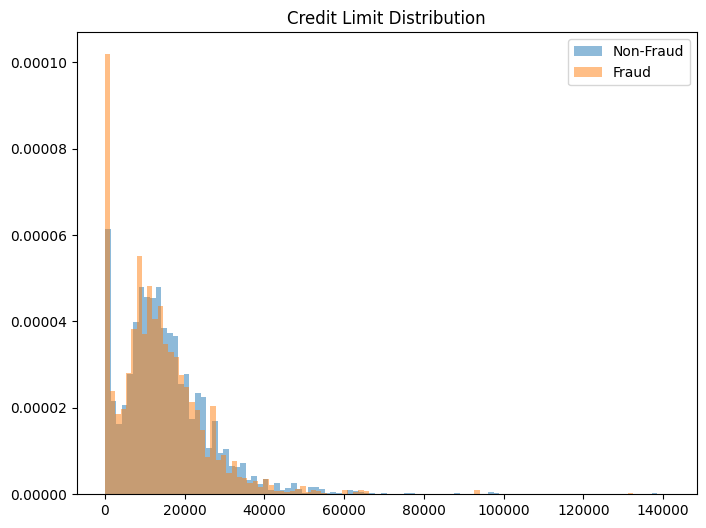

In [7]:
plt.figure(figsize=(8,6))
plt.hist(non["credit_limit"], bins=100, alpha=0.5, label="Non-Fraud", density=True)
plt.hist(fraud["credit_limit"], bins=100, alpha=0.5, label="Fraud", density=True)

plt.legend()
plt.title("Credit Limit Distribution")
plt.show()


num_card_issued

In [9]:
df["num_cards_issued"].value_counts()

num_cards_issued
2    2684257
1    2585556
3      42898
Name: count, dtype: int64

In [25]:
p = (
    df.groupby(["fraud", "num_cards_issued"])
      .size()
      .groupby(level=0)
      .apply(lambda x: x / x.sum())
      .unstack(fill_value=0)
)

p

,num_cards_issued,1,2,3
fraud,fraud,,,
0,0,0.486670,0.50526,0.008070
1,1,0.488814,0.49974,0.011446


/home/nakyung/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


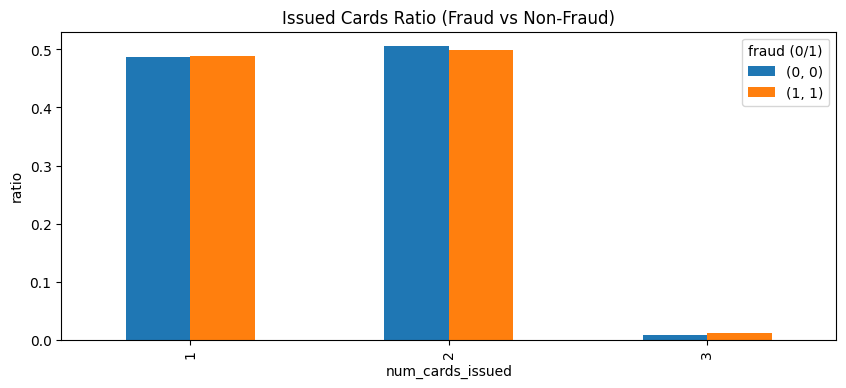

In [26]:
p = p.T
ax = p.sort_index().plot(kind="bar", figsize=(10,4))
ax.set_xlabel("num_cards_issued")
ax.set_ylabel("ratio")
ax.set_title("Issued Cards Ratio (Fraud vs Non-Fraud)")
ax.legend(title="fraud (0/1)")

num_credit_cards

In [22]:
p = (
    df.groupby(["fraud", "num_credit_cards"])
      .size()
      .groupby(level=0)
      .apply(lambda x: x / x.sum())
      .unstack(fill_value=0)
)

p

,num_credit_cards,1,2,3,4,5,6,7,8,9
fraud,fraud,,,,,,,,,
0,0,0.066878,0.126280,0.227335,0.266365,0.169337,0.090122,0.036630,0.015493,0.001561
1,1,0.039282,0.118106,0.207596,0.257024,0.189906,0.106790,0.046176,0.029787,0.005333


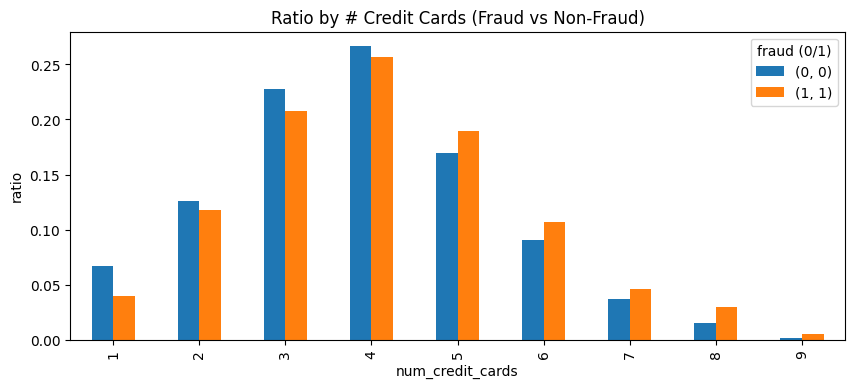

In [24]:
p = p.T
ax = p.sort_index().plot(kind="bar", figsize=(10,4))
ax.set_xlabel("num_credit_cards")
ax.set_ylabel("ratio")
ax.set_title("Ratio by # Credit Cards (Fraud vs Non-Fraud)")
ax.legend(title="fraud (0/1)")

In [28]:
df.groupby("num_credit_cards")["fraud"].agg(
    ["count", "mean"]
)

,count,mean
num_credit_cards,,
1,355089,0.000850
2,670827,0.001354
3,1207615,0.001322
4,1415048,0.001396
5,899795,0.001623
6,478920,0.001714
7,194676,0.001824
8,82419,0.002778
9,8322,0.004927


In [29]:
client = (
    df.groupby("client_id")
      .agg(
          num_cards=("num_credit_cards","max"),
          num_tx=("fraud","count"),
          fraud_rate=("fraud","mean")
      )
)
client.groupby("num_cards")["fraud_rate"].mean()


num_cards
1    0.001104
2    0.001589
3    0.002346
4    0.001714
5    0.001973
6    0.001892
7    0.002197
8    0.002906
9    0.004237
Name: fraud_rate, dtype: float64

In [30]:
X = client[["num_cards", "num_tx"]]
X = sm.add_constant(X)
y = (client["fraud_rate"] > 0).astype(int)

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.625521
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             fraud_rate   No. Observations:                 1209
Model:                          Logit   Df Residuals:                     1206
Method:                           MLE   Df Model:                            2
Date:                Sat, 14 Feb 2026   Pseudo R-squ.:                 0.02247
Time:                        11:13:28   Log-Likelihood:                -756.25
converged:                       True   LL-Null:                       -773.64
Covariance Type:            nonrobust   LLR p-value:                 2.822e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3346      0.187     -1.792      0.073      -0.701       0.031
num_cards      0.2090      0.

> High-card holders 그룹에서 fraud 비중이 상대적으로 더 높아진다

In [54]:
results = []

for col in ["yearly_income",
            "credit_score",
            "total_debt",
            "credit_limit",
            "num_credit_cards"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])


,feature,coef,OR,p_value
0,yearly_income,-0.000005,0.999995,7.885687e-20
1,credit_score,0.000009,1.000009,9.588085e-01
2,total_debt,-0.000002,0.999998,2.161809e-20
3,credit_limit,-0.000015,0.999985,1.079906e-42
4,num_credit_cards,0.110118,1.116410,3.760647e-54


months_from_account

In [35]:
df["months_from_account"].describe()

count    5.312525e+06
mean     6.807525e+01
std      4.576855e+01
min      0.000000e+00
25%      3.300000e+01
50%      6.100000e+01
75%      9.600000e+01
max      2.990000e+02
Name: months_from_account, dtype: float64

In [36]:
p = df[df["months_from_account"]<0]
len(p)

0

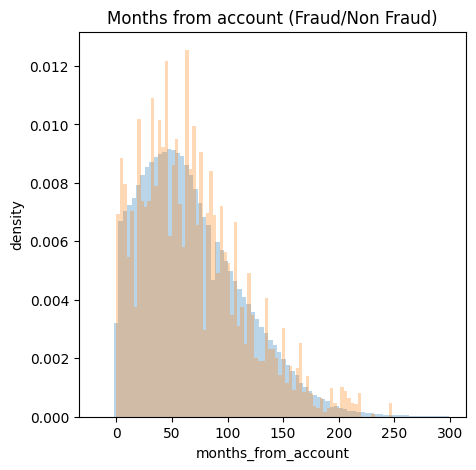

In [40]:
plt.figure(figsize=(5,5))
plt.hist(non["months_from_account"], bins=80, density=True, alpha=0.3, label="Non-Fraud")
plt.hist(fraud["months_from_account"], bins=80, density=True, alpha=0.3, label="Fraud")
plt.xlabel("months_from_account")
plt.title("Months from account (Fraud/Non Fraud)")
plt.ylabel("density")
plt.show()

years_since_pin_change

In [41]:
df["years_since_pin_change"].describe()

count    5.312525e+06
mean     2.120739e+00
std      2.216062e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      1.300000e+01
Name: years_since_pin_change, dtype: float64

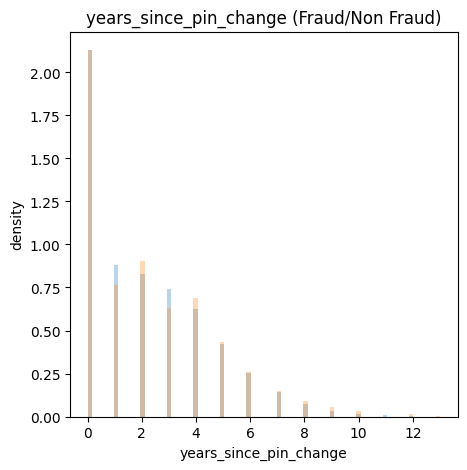

In [42]:
plt.figure(figsize=(5,5))
plt.hist(non["years_since_pin_change"], bins=80, density=True, alpha=0.3, label="Non-Fraud")
plt.hist(fraud["years_since_pin_change"], bins=80, density=True, alpha=0.3, label="Fraud")
plt.xlabel("years_since_pin_change")
plt.title("years_since_pin_change (Fraud/Non Fraud)")
plt.ylabel("density")
plt.show()

current_age

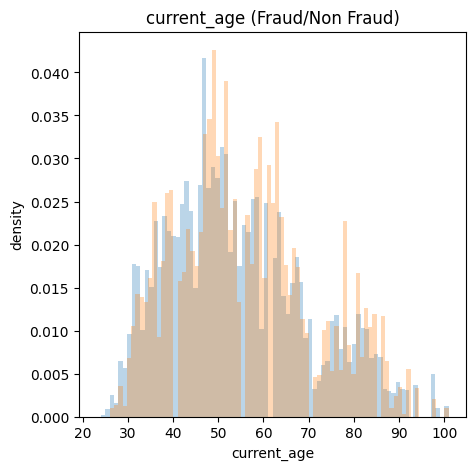

In [43]:
plt.figure(figsize=(5,5))
plt.hist(non["current_age"], bins=80, density=True, alpha=0.3, label="Non-Fraud")
plt.hist(fraud["current_age"], bins=80, density=True, alpha=0.3, label="Fraud")
plt.xlabel("current_age")
plt.title("current_age (Fraud/Non Fraud)")
plt.ylabel("density")
plt.show()

male

In [48]:
df.groupby("fraud")["male"].mean()

fraud
0    0.489206
1    0.482830
Name: male, dtype: float64

In [50]:
results = []

for col in ["months_from_account",
            "years_since_pin_change",
            "current_age",
            "male",
            "num_credit_cards"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])


,feature,coef,OR,p_value
0,months_from_account,0.000289,1.000289,2.439538e-01
1,years_since_pin_change,0.023212,1.023483,3.788355e-06
2,current_age,0.006636,1.006658,1.018238e-20
3,male,-0.025523,0.974800,2.637827e-01
4,num_credit_cards,0.110118,1.116410,3.760647e-54


In [53]:
df.drop(columns=["male", "months_from_account"], inplace=True)

---

# 4️⃣ History

이 merchant는 과거에 refund가 얼마나 자주 발생했는가?

---

# Interaction

In [61]:
mcc_ohe = pd.get_dummies(df["mcc"], prefix="mcc")
num_df = df.select_dtypes(include="number")
corr_df = pd.concat([num_df, mcc_ohe], axis=1)
corr = corr_df.corr()

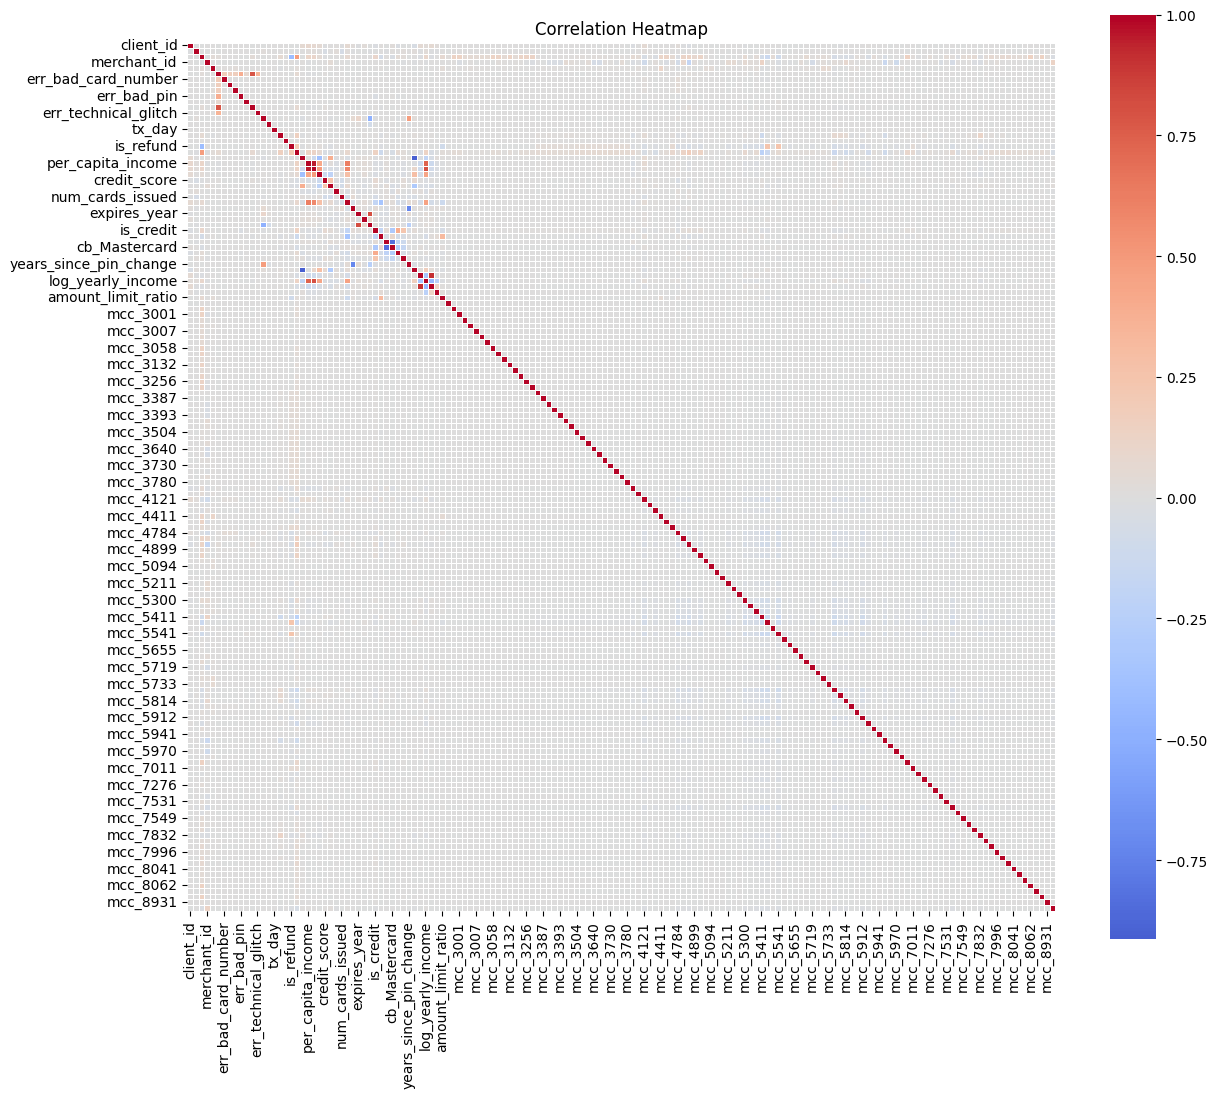

In [62]:
plt.figure(figsize=(14,12))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Heatmap")
plt.show()


In [65]:
corr.to_csv("corr")

In [66]:
corr

,client_id,card_id,amount,merchant_id,fraud,has_error,err_bad_card_number,err_bad_expiration,err_bad_cvv,err_bad_pin,...,mcc_8011,mcc_8021,mcc_8041,mcc_8043,mcc_8049,mcc_8062,mcc_8099,mcc_8111,mcc_8931,mcc_9402
client_id,1.000000,-0.015136,-0.004101,0.001927,-0.000552,-0.003337,0.001627,0.001609,0.002479,-0.000127,...,-0.001264,-0.003453,-0.000869,-0.001622,-0.000291,0.000113,-0.000951,-9.174900e-04,-0.000939,-0.006332
card_id,-0.015136,1.000000,-0.004748,-0.006733,-0.000242,-0.002960,0.000786,0.000348,0.000030,-0.000201,...,-0.001333,-0.000539,-0.003429,-0.003799,-0.003306,0.000154,-0.002080,-2.117567e-04,-0.000254,-0.000195
amount,-0.004101,-0.004748,1.000000,-0.014670,0.033762,0.026606,0.004730,0.003793,0.005896,-0.001647,...,0.069484,0.069040,0.034697,0.036890,0.035003,0.136357,0.026875,1.366169e-01,0.027969,-0.029856
merchant_id,0.001927,-0.006733,-0.014670,1.000000,0.004015,-0.005357,-0.006270,-0.005422,-0.004650,0.000956,...,0.004954,0.001923,0.005303,0.002288,0.005951,-0.005546,0.004961,4.130845e-03,0.001715,0.119890
fraud,-0.000552,-0.000242,0.033762,0.004015,1.000000,0.008570,0.008431,0.007415,0.023855,0.001021,...,-0.000944,-0.001083,-0.000688,-0.000329,-0.000883,0.001181,-0.000965,-8.723295e-04,-0.000625,-0.002606
has_error,-0.003337,-0.002960,0.026606,-0.005357,0.008570,1.000000,0.191480,0.170190,0.168919,0.389398,...,-0.000772,0.000490,0.000656,0.001280,-0.000087,-0.001359,-0.000230,-1.535423e-03,0.000662,-0.005663
err_bad_card_number,0.001627,0.000786,0.004730,-0.006270,0.008431,0.191480,1.000000,0.005192,0.004159,-0.001206,...,-0.001047,-0.001206,-0.000670,-0.000848,-0.000679,-0.000400,-0.000808,-5.580517e-04,-0.000400,-0.002109
err_bad_expiration,0.001609,0.000348,0.003793,-0.005422,0.007415,0.170190,0.005192,1.000000,0.003586,-0.001072,...,-0.000931,-0.001072,-0.000596,-0.000754,-0.000603,-0.000356,-0.000718,-4.960053e-04,-0.000355,-0.001875
err_bad_cvv,0.002479,0.000030,0.005896,-0.004650,0.023855,0.168919,0.004159,0.003586,1.000000,-0.001064,...,-0.000924,-0.001064,-0.000591,-0.000748,-0.000599,-0.000353,-0.000713,-4.923016e-04,-0.000353,-0.001861
err_bad_pin,-0.000127,-0.000201,-0.001647,0.000956,0.001021,0.389398,-0.001206,-0.001072,-0.001064,1.000000,...,-0.001419,-0.000139,-0.000809,0.000028,-0.000149,-0.000351,-0.000495,6.950713e-04,0.000116,0.000497


In [68]:
corr = df.select_dtypes(include=[np.number]).corr()

corr_values = corr.unstack().reset_index()
corr_values.columns = ["feature1", "feature2", "corr"]

corr_values = corr_values[corr_values["feature1"] != corr_values["feature2"]]

corr_values = corr_values[
    corr_values["feature1"] < corr_values["feature2"]
]

corr_values["abs_corr"] = corr_values["corr"].abs()

top_corr = corr_values.sort_values("abs_corr", ascending=False)

top_corr.head(50)

,feature1,feature2,corr,abs_corr
988,per_capita_income,yearly_income,0.948741,0.948741
960,current_age,years_to_retirement,-0.912415,0.912415
1929,income_ratio_region,log_income_ratio_region,0.903904,0.903904
1691,cb_Mastercard,cb_Visa,-0.830724,0.830724
1412,expires_year,months_to_expire,0.812019,0.812019
1954,log_yearly_income,yearly_income,0.803725,0.803725
511,err_insufficient_balance,has_error,0.787043,0.787043
1953,log_yearly_income,per_capita_income,0.731381,0.731381
1373,year_pin_last_changed,years_since_pin_change,-0.725187,0.725187
1309,credit_limit,per_capita_income,0.614335,0.614335


In [70]:
target_corr = corr["fraud"]

target_corr_sorted = target_corr.loc[
    target_corr.abs().sort_values(ascending=False).index
]

target_corr_sorted


fraud                       1.000000
amount_limit_ratio          0.034451
amount                      0.033762
log_abs_amount              0.025747
err_bad_cvv                 0.023855
tx_hour                    -0.011640
has_error                   0.008570
err_bad_card_number         0.008431
err_bad_expiration          0.007415
is_prepaid                  0.007114
num_credit_cards            0.006727
credit_limit               -0.005871
weekday                     0.005560
log_yearly_income          -0.004851
years_to_retirement        -0.004805
current_age                 0.004053
merchant_id                 0.004015
total_debt                 -0.004006
yearly_income              -0.003936
per_capita_income          -0.003585
tx_month                    0.003310
cb_Discover                 0.003070
log_income_ratio_region     0.002465
year_pin_last_changed      -0.002452
cb_Visa                    -0.002372
years_since_pin_change      0.002006
expires_year               -0.001982
h

**중복 수준 (0.8 이상)**

per_capita_income ↔ yearly_income (0.95)

current_age ↔ years_to_retirement (-0.91)

income_ratio_region ↔ log_income_ratio_region (0.90)

cb_Mastercard ↔ cb_Visa (-0.83)

expires_year ↔ months_to_expire (0.81)

log_yearly_income ↔ yearly_income (0.80)